<img src="header-exploration.png"/>

# Objectif du projet

# Objective of the project

> Des relevés minutieux ont été effectués par les agents de la ville en de Seattle 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.
> - Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)
> - Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

>Les objectifs sont ainsi :
> - Réaliser une analyse exploratoire.
> - Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

> Careful readings were taken by city officials in Seattle 2016. However, these readings are expensive to obtain, and from those already taken, you want to attempt to predict CO2 emissions and total fuel consumption. energy from non-residential buildings for which they have not yet been measured.
> - Your prediction will be based on the structural data of the buildings (size and use of the buildings, date of construction, geographical location, ...)
> - You are also looking to evaluate the interest of the "ENERGY STAR Score" for the prediction of emissions, which is tedious to calculate with the approach currently used by your team. You will integrate it into the modeling and judge its interest.

>The objectives are as follows:
> - Carry out an exploratory analysis.
> - Test different prediction models in order to best respond to the problem.

# Execution du notebook

# Running the notebook

Le présent notebook suppose l'arborescence suivante, pour le chargement des données et l'écriture des résultats : 

This notebook assumes the following tree, for loading data and writing results:

```bash
├───data
│   ├───processed
│   └───raw
│       ├───2015-building-energy-benchmarking.csv
│       └───2016-building-energy-benchmarking.csv
└───notebooks
    ├───1_exploration.ipynb
    ├───2_analysis.ipynb
    ├───3_models.ipynb
    ├───header-analysis.png
    ├───header-exploration.png
    ├───header-models.png
    ├───Map_of_Seattle_divided_by_districts.png
    ├───studied-zone-height.png
    └───studied-zone-width.png
```

# Source des données

# Source of data

 - https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
 - https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

# Initialisation du projet

# Project initialization

In [69]:
# Constants
DELETE_NAN_LINES = True

In [70]:
# Math & data
import numpy as np
import scipy
from scipy.stats import zscore
import pandas as pd
from datetime import date
import itertools
import re

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats

import pickle

In [71]:
# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Feature selection
from sklearn.model_selection import GridSearchCV, KFold

# ML
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.dummy import DummyClassifier

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [72]:
import statsmodels.api as sm

In [73]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# Personal libraries
import DisplotData, DisplotML, PwePwocess, Funktiuns, MLstuff
from DisplotData import bcolors

In [75]:
# Display options
pd.set_option("display.max_columns", 50) # None
pd.set_option("display.max_rows", 50) # None

In [76]:
# Constants
EPSILON = 1.e-12
EPSILON_GFA = 1 # For squared feet
TOL = 1.05 # 5% of tolerance for comparisons

# Chargement des données

# Loading data

In [77]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'

In [78]:
df_2015 = pd.read_csv(data_raw_dir+'2015-building-energy-benchmarking.csv', delimiter=',')

In [79]:
df_2016 = pd.read_csv(data_raw_dir+'2016-building-energy-benchmarking.csv', delimiter=',')

# Exploration des données

# Data exploration

## Variables initiales

## Initial variables

Données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Declarative data of the commercial operating permit (size and use of buildings, mention of recent work, date of construction, etc.)

In [80]:
df_2015.head(50)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576
5,9,2015,Nonresidential COS,Other,WEST PRECINCT (SEATTLE POLICE),660000560,"{'latitude': '47.6164389', 'longitude': '-122....",7,DOWNTOWN,1999,1,2.0,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,NaN,135.7,146.9,313.5,321.6,12051984.0,13045258.0,0.0,2130921.0,7271004.0,47813.0,4781283.0,0.0,304.62,2.81,No,NaN,Compliant,NaN,NaN,56.0,NaN,7.0,19576
6,10,2015,NonResidential,Hotel,CAMLIN WORLDMARK HOTEL,660000825,"{'latitude': '47.6141141', 'longitude': '-122....",7,DOWNTOWN,1926,1,11.0,83008,0,83008,Hotel,Hotel,81352.0,NaN,NaN,NaN,NaN,NaN,25.0,76.9,79.6,149.5,158.2,6252842.0,6477493.0,0.0,785342.0,2679698.0,35733.0,3573255.0,0.0,208.46,2.37,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
7,11,2015,NonResidential,Other,PARAMOUNT THEATER,660000955,"{'latitude': '47.61290234', 'longitude': '-122...",7,DOWNTOWN,1926,1,8.0,102761,0,102761,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761.0,NaN,NaN,NaN,NaN,NaN,NaN,62.5,71.8,152.2,160.4,6426022.0,7380086.0,2003108.0,1203937.0,4108004.0,3151.0,315079.0,0.0,199.99,1.77,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
8,12,2015,NonResidential,Hotel,COURTYARD BY MARRIOTT - ALASKA BLDG SEATTLE

In [81]:
df_2016.head(30)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2.003882e+06,1.156514e+06,3946027.0,12764.529300,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.000000e+00,9.504252e+05,3242851.0,51450.816410,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,2.156655e+07,1.451544e+07,49526664.0,14938.000000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2.214446e+06,8.115253e+05,2768924.0,18112.130860,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.000000e+00,1.573449e+06,5368607.0,88039.984380,8803998.0,False,NaN,Compliant,NaN,505.01,2.88
5,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.0,0660000560,7,DOWNTOWN,47.61623,-122.33657,1999,1.0,2,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,NaN,136.100006,141.600006,316.299988,320.500000,1.208662e+07,1.258171e+07,0.000000e+00,2.160444e+06,7371434.0,47151.816410,4715182.0,False,NaN,Compliant,NaN,301.81,3.10
6,10,2016,NonResidential,Hotel,Camlin,1619 9th Avenue,Seattle,WA,98101.0,0660000825,7,DOWNTOWN,47.61390,-122.33283,1926,1.0,11,83008,0,83008,Hotel,Hotel,81352.0,NaN,NaN,NaN,NaN,NaN,27.0,70.800003,74.500000,146.600006,154.699997,5.758795e+06,6.062768e+06,0.000000e+00,8.239199e+05,2811215.0,29475.800780,2947580.0,False,NaN,Compliant,NaN,176.14,2.12
7,11,2016,NonResidential,Other,Paramount Theatre,911 Pine St,Seattle,WA,98101.0,0660000955,7,DOWNTOWN,47.61327,-122.33136,1926,1.0,8,102761,0,102761,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761.0,NaN,NaN,NaN,NaN,NaN,NaN,61.299999,68.800003,141.699997,152.300003,6.298132e+06,7.067882e+06,2.276286e+06,1.065843e+06,3636655.0,3851.890137,385189.0,False,NaN,Compliant,NaN,221.51,2.16
8,12,2016,NonResidential,Hotel,311wh-Pioneer Square,612 2nd Ave,Seattle,WA,98104.0,0939000080,7,DOWNTOWN,47.60294,-122.33263,1904,1.0,

In [82]:
df_2015.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'DefaultData', '

In [83]:
df_2016.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [84]:
df_2015.shape

(3340, 47)

In [85]:
df_2016.shape

(3376, 46)

Ah, au moins un colonne diffère entre les deux fichiers.

Ah, at least one column differs between the two files.

In [86]:
cols_2015 = set(df_2015.columns)
cols_2016 = set(df_2016.columns)

In [87]:
cols_in_2015_not_in_2016 = cols_2015 - cols_2016
cols_in_2015_not_in_2016

{'2010 Census Tracts',
 'City Council Districts',
 'Comment',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)',
 'SPD Beats',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'Zip Codes'}

In [88]:
cols_in_2016_not_in_2015 = cols_2016 - cols_2015
cols_in_2016_not_in_2015

{'Address',
 'City',
 'Comments',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

Les deux fichiers n'ont pas exactement la même structure. Il faut peut-être :
- renommer simplement des colonnes
- modifier les valeurs pour les rendre homogènes entre elles.

The two files do not have exactly the same structure. You may need:
- simply rename columns
- modify the values ​​to make them consistent with each other.

In [89]:
df_2015.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
count,3340.000000,3340.0,3340.000000,3340.000000,3340.000000,3332.000000,3.340000e+03,3340.000000,3.340000e+03,3.204000e+03,1559.000000,560.000000,2560.000000,3330.000000,3330.000000,3330.000000,3330.000000,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3.330000e+03,3330.000000,3330.000000,224.000000,3338.000000,213.000000,3338.000000,3340.000000
mean,20522.168263,2015.0,4.450898,1967.624850,1.035629,4.682173,9.077289e+04,11054.032335,7.971886e+04,7.488154e+04,27675.646568,10755.708929,67.894141,53.626126,57.586547,132.779730,138.936036,4.983106e+06,5.203055e+06,2.502851e+05,1.017897e+06,3.473209e+06,1.253304e+04,1.253304e+06,7.142301e+03,110.094102,0.985339,123.062500,32.380168,1.347418,24.825644,18786.680240
std,11511.515874,0.0,2.127203,32.949847,0.784463,5.458460,1.493058e+05,35296.330507,1.292314e+05,1.236249e+05,52480.843425,22618.529737,27.154057,53.893311,55.604963,131.943223,131.359121,1.375330e+07,1.400757e+07,3.481900e+06,2.789931e+06,9.519639e+06,4.415142e+04,4.415142e+06,1.962790e+05,409.450179,1.637172,5.812128,19.907567,0.477272,15.006287,588.604192
min,1.000000,2015.0,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,-3.000000,-5.055000e+04,5.872000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,116.000000,1.000000,1.000000,1.000000,17916.000000
25%,19921.750000,2015.0,3.000000,1947.000000,1.000000,2.000000,2.848700e+04,0.000000,2.668300e+04,2.500000e+04,4959.000000,2385.250000,51.750000,27.300000,29.700000,73.500000,80.300000,9.139300e+05,9.883248e+05,0.000000e+00,1.864908e+05,6.363322e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.265000,0.080000,117.000000,14.000000,1.000000,10.000000,18379.000000
50%,22977.000000,2015.0,4.000000,1973.000000,1.000000,4.000000,4.385500e+04,0.000000,4.132600e+04,3.900000e+04,10600.000000,5019.500000,76.000000,37.400000,40.900000,95.000000,102.800000,1.776219e+06,1.953996e+06,0.000000e+00,3.400320e+05,1.160236e+06,2.945500e+03,2.945770e+05,0.000000e+00,32.740000,0.460000,123.000000,33.000000,1.000000,26.000000,18390.000000
75%,25748.000000,2015.0,7.000000,1996.000000,1.000000,5.000000,8.842800e+04,4304.250000,7.872600e+04,7.206750e+04,26224.500000,10275.000000,90.000000,59.875000,65.575000,143.900000,151.275000,4.044277e+06,4.368462e+06,0.000000e+00,8.061935e+05,2.750847e+06,1.115325e+04,1.115366e+06,0.000000e+00,88.642500,1.180000,125.500000,50.000000,2.000000,38.000000,19576.000000
max,50059.000000,2015.0,7.000000,2015.000000,39.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,1.719643e+06,686750.000000,303910.000000,100.000000,800.600000,800.600000,2511.100000,2511.000000,2.958126e+08,2.977410e+08,1.278697e+08,8.344505e+07,2.847263e+08,1.364484e+06,1.364484e+08,8.269669e+06,11824.890000,31.380000,135.000000,61.000000,2.000000,51.000000,19584.000000


Des valeurs négatives pour :
- `'PropertyGFAParking'` : bizarre
- `'PropertyGFABuilding(s)'` : bizarre
- `'SourceEUI(kBtu/sf)'` : bizarre
- `'SourceEUIWN(kBtu/sf)'` (peut-être normal)

Negative values ​​for:
- `'PropertyGFAParking'`: weird
- `'PropertyGFABuilding(s)'`: weird
- `'SourceEUI(kBtu/sf)'`: weird
- `'SourceEUIWN(kBtu/sf)'` (maybe normal)

In [90]:
df_2016.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


Des valeurs négatives pour :
- `'SourceEUIWN(kBtu/sf)'` (peut-être normal)
- `'Electricity(kWh)'` (et `'Electricity(kBtu)'`) (peut-être normal si la propriété produit son électricité)
- `'TotalGHGEmissions'` : plus difficile d'être normal
- `'GHGEmissionsIntensity'` : plus difficile d'être normal

Negative values ​​for:
- `'SourceEUIWN(kBtu/sf)'` (maybe normal)
- `'Electricity(kWh)'` (and `'Electricity(kBtu)'`) (perhaps normal if the property produces its own electricity)
- `'TotalGHGEmissions'`: more difficult to be normal
- `'GHGEmissionsIntensity'`: more difficult to be normal

### Description des colonnes de 2015/2016

### Description of 2015/2016 columns

- `'OSEBuildingID'` : Un identifiant unique attribué à chaque propriété couverte par la Seattle Benchmarking Ordinance à des fins de suivi et d'identification.
- `'DataYear'` : Année de la donnée/Année civile (janvier-décembre) représentée par chaque enregistrement de données.
- `'BuildingType'` : Classification des types de bâtiments de la ville de Seattle.
- `'PrimaryPropertyType'` : L'utilisation principale d'une propriété (par exemple, bureau, magasin de détail). L'usage principal est défini comme une fonction qui représente plus de 50 % d'un bien. Il s'agit du champ Type de propriété - EPA calculée de Portfolio Manager.
- `'PropertyName'` : Nom de propriété officiel ou commun/Nom de propriété officiel ou commun tel qu'il est entré dans le gestionnaire de portefeuille de l'EPA.
- `'TaxParcelIdentificationNumber'` : Code PIN du comté de King
- `'Location'` : emplacement
- `'CouncilDistrictCode'` : Propriété District du conseil de la ville de Seattle
- `'Neighborhood'` : Quartier/Zone de voisinage de propriété définie par le département des quartiers de la ville de Seattle.
- `'YearBuilt'` : Année au cours de laquelle une propriété a été construite ou a subi une **rénovation complète**
- `'NumberofBuildings'` : Nombre de bâtiments/Nombre de bâtiments inclus dans le rapport de la propriété. Dans les cas où une propriété est signalée comme un campus, plusieurs bâtiments peuvent être inclus dans un seul rapport.
- `'NumberofFloors'` : Nombre d'étages/Nombre d'étages signalés dans Portfolio Manager
- `'PropertyGFATotal'` : Surface de plancher brute totale du bâtiment et du stationnement
- `'PropertyGFAParking'` : Espace total en pieds carrés de tous les types de stationnement (entièrement fermé, partiellement fermé et ouvert)
- `'PropertyGFABuilding(s)'` : Espace au sol total en pieds carrés entre les surfaces extérieures des murs d'enceinte d'un bâtiment. Cela comprend toutes les zones à l'intérieur du ou des bâtiments, telles que l'espace des locataires, les espaces communs, les cages d'escalier, les sous-sols, le stockage, etc.
- `'ListOfAllPropertyUseTypes'` : liste de tous les types d'utilisation de la propriété/Toutes les utilisations de la propriété signalées dans Portfolio Manager
- `'LargestPropertyUseType'` : Type d'utilisation de la plus grande propriété/La plus grande utilisation d'une propriété (par exemple, bureau, magasin de détail) par surface de plancher.
- `'LargestPropertyUseTypeGFA'` : Type d'utilisation de la plus grande propriété, surface de plancher/La surface de plancher brute (GFA) de la plus grande utilisation de la propriété.
- `'SecondLargestPropertyUseType'` : Type d'utilisation de la deuxième plus grande propriété
- `'SecondLargestPropertyUseTypeGFA'` : Type d'utilisation de la deuxième plus grande propriété, GFA
- `'ThirdLargestPropertyUseType'` : Type d'utilisation de la troisième plus grande propriété
- `'ThirdLargestPropertyUseTypeGFA'` : Type d'utilisation de la troisième plus grande propriété, GFA
- `'YearsENERGYSTARCertified'` : Années de certification ENERGYSTAR/Années pendant lesquelles la propriété a reçu la certification ENERGY STAR.
- `'ENERGYSTARScore'` : Une EPA a calculé une note de 1 à 100 qui évalue la performance énergétique globale d'une propriété, sur la base de données nationales pour contrôler les différences entre le climat, les utilisations des bâtiments et les opérations. Un score de 50 représente la médiane nationale.
- `'SiteEUI(kBtu/sf)'` : L'intensité de consommation d'énergie du site (IUE) est la consommation d'énergie du site d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie du site est le montant annuel de toute l'énergie consommée par la propriété sur le site, tel qu'indiqué sur les factures de services publics. L'IE du site est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.
- `'SiteEUIWN(kBtu/sf)'` : L'intensité de consommation d'énergie du site (EUI) normalisée par les conditions météorologiques (WN) est l'énergie du site WN d'une propriété divisée par sa surface de plancher brute (en pieds carrés). L'énergie du site WN est la consommation d'énergie du site que la propriété aurait consommée dans des conditions météorologiques moyennes sur 30 ans. L'IUE du site WN est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.
- `'SourceEUI(kBtu/sf)'` : L'intensité de consommation d'énergie à la source (IUE) est la consommation d'énergie à la source d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie à la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes de production, de transmission et de distribution. Source EUI est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.
- `'SourceEUIWN(kBtu/sf)'` : L'intensité d'utilisation de l'énergie à la source (EUI) normalisée par les conditions météorologiques (WN) est l'énergie à la source WN d'une propriété divisée par sa surface de plancher brute. L'énergie à la source WN est l'utilisation de l'énergie à la source que la propriété aurait consommée dans des conditions météorologiques moyennes sur 30 ans. WN Source EUI est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré.
- `'SiteEnergyUse(kBtu)'` : La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie.
- `'SiteEnergyUseWN(kBtu)'` : La quantité annuelle d'énergie consommée par la propriété normalisée par les conditions météorologiques (WN) à partir de toutes les sources d'énergie.
- `'SteamUse(kBtu)'` : La quantité annuelle de vapeur de quartier consommée par la propriété sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).
- `'Electricity(kWh)'` : La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes renouvelables sur place, mesurée en kWh.
- `'Electricity(kBtu)'` : La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes renouvelables sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).
- `'NaturalGas(therms)'` : La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en thermes.
- `'NaturalGas(kBtu)'` : La quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en milliers d'unités thermiques britanniques (kBtu).
- `'OtherFuelUse(kBtu)'` : Utilisation d'autres combustibles, mesurée en milliers d'unités thermiques britanniques (kBtu).
- `'GHGEmissions(MetricTonsCO2e)'` : La quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz d'oxyde nitreux libérés dans l'atmosphère en raison de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent en dioxyde de carbone. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light. Cela utilise le facteur d'émissions 2015 de Seattle City Light de 52,44 lb CO2e/MWh. Facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu. Facteur de gaz provenant de EPA Portfolio Manager = 53,11 kg CO2e/MBtu.
- `'GHGEmissionsIntensity(kgCO2e/ft2)'` : Émissions totales de gaz à effet de serre divisées par la surface de plancher brute de la propriété, mesurée en kilogrammes d'équivalent en dioxyde de carbone par pied carré. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light.
- `'DefaultData'` : Donnée par défaut/La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété.
- `'Comment'/'Comments'` : Commentaire/Commentaires d'un propriétaire ou d'un agent du bâtiment pour mettre en contexte la consommation d'énergie du bâtiment.
- `'ComplianceStatus'` : Etat de conformité/Si une propriété a satisfait aux exigences d'analyse comparative énergétique pour l'année de déclaration en cours.
- `'Outlier'` : Valeur aberrante/Whether a property is a high or low outlier (Y/N)
- `'2010 Census Tracts'` : Secteurs du recensement de 2010
- `'Seattle Police Department Micro Community Policing Plan Areas'` : Zones du plan de micro-police communautaire du département de police de Seattle (??)
- `'City Council Districts'` : Districts du conseil municipal
- `'SPD Beats'` : Après recherches, cela semble être le découpage des zones d'intervention de la Police (https://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::seattle-police-beats-2015-2017/about)
- `'Zip Codes'` : Codes Zip

**Colonnes spécifiques de 2016 :**
- `'Address'` : Adresse municipale de la propriété
- `'City'` : Ville de la propriété
- `'State'` : Etat (uni ^^) de la propriété
- `'ZipCode'` : Code Zip
- `'Latitude'` : Latitude de la propriété
- `'Longitude'` : Longitude de la propriété
- `'TotalGHGEmissions'` : La quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz d'oxyde nitreux libérés dans l'atmosphère en raison de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent en dioxyde de carbone. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light. Cela utilise le facteur d'émissions 2015 de Seattle City Light de 52,44 lb CO2e/MWh jusqu'à ce que le facteur 2016 soit disponible. Facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu. Facteur de gaz provenant de EPA Portfolio Manager = 53,11 kg CO2e/MBtu.
- `'GHGEmissionsIntensity'` : Émissions totales de gaz à effet de serre divisées par la surface de plancher brute de la propriété, mesurée en kilogrammes d'équivalent en dioxyde de carbone par pied carré. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light

**2016 specific columns:**
 - `Address`: Property street address
 - `City`: Property city
 - `State`: Property state
 - `ZipCode`: Property zip
 - `Latitude`: Property latitude.
 - `Longitude`: Property longitude.
 - `YearBuilt`: Year in which a property was constructed or underwent a complete renovation.
 - `TotalGHGEmissions`: The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. 
 - `GHGEmissionsIntensity`: Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources

**Remarque :** les données 2016 sont un peu mieux décrites.

**Note:** 2016 data is a little better described.

### Contrôle des surfaces totales

### Control of total surfaces

In [91]:
df_2015['TOTAL'] = df_2015['PropertyGFAParking'] + df_2015['PropertyGFABuilding(s)']
df_2015['ZERO'] = df_2015['PropertyGFATotal'] - df_2015['TOTAL']

In [92]:
df_2015.loc[df_2015['ZERO']!=0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,TOTAL,ZERO


Les surfaces totales, parking et buildings sont bien toutes **cohérentes**.

The total surfaces, car park and buildings are all **coherent**.

In [93]:
df_2015.drop(['TOTAL', 'ZERO'], axis=1, inplace=True)

### Fusion des variables équivalentes

### Merge equivalent variables

D'une manière générale, on adoptera les noms de données 2016.

In general, the 2016 data names will be adopted.

In [94]:
dict_fus = {} # Column renaming dictionary
droped_cols = [] # List of columns that will be deleted

La latitude et longitude semblent avoir été sorties de la variable `'Address'`. Pas sûr qu'elles jouent un rôle important, si on reste sur la zone de Seattle :

The latitude and longitude appear to have been taken from the `'Address'' variable. Not sure that they play an important role, if we stay in the Seattle area:

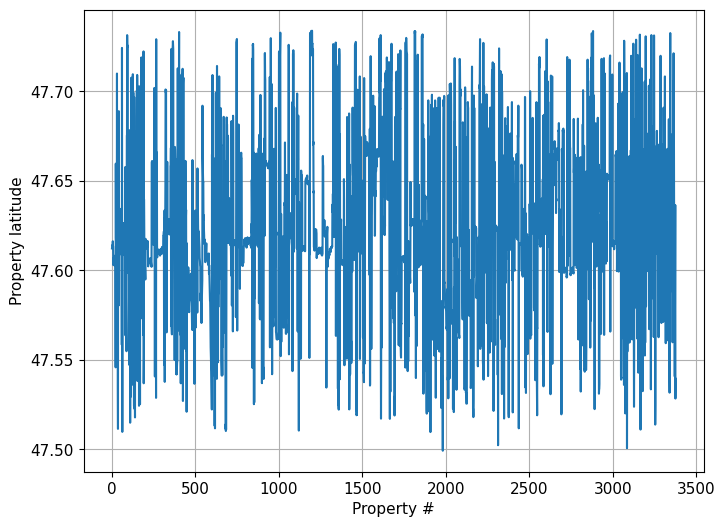

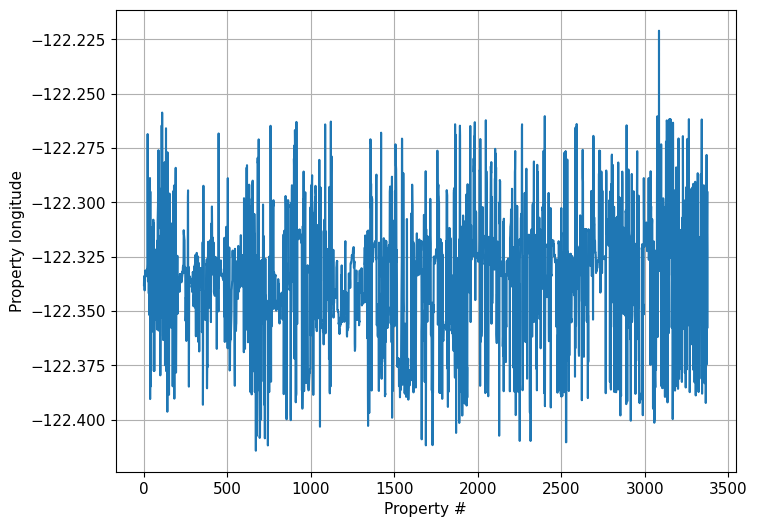

In [95]:
plt.rcParams['figure.figsize'] = [8, 6]
for col in ['Latitude', 'Longitude']:
    plt.figure()
    df_2016[col].plot()
    plt.grid('on')
    plt.xlabel('Property #')
    plt.ylabel(f'Property {col.lower()}')

In [96]:
print(df_2016['Latitude'].min(), df_2016['Latitude'].max())

47.49917 47.73387


In [97]:
print(df_2016['Longitude'].min(), df_2016['Longitude'].max())

-122.41425 -122.2209659


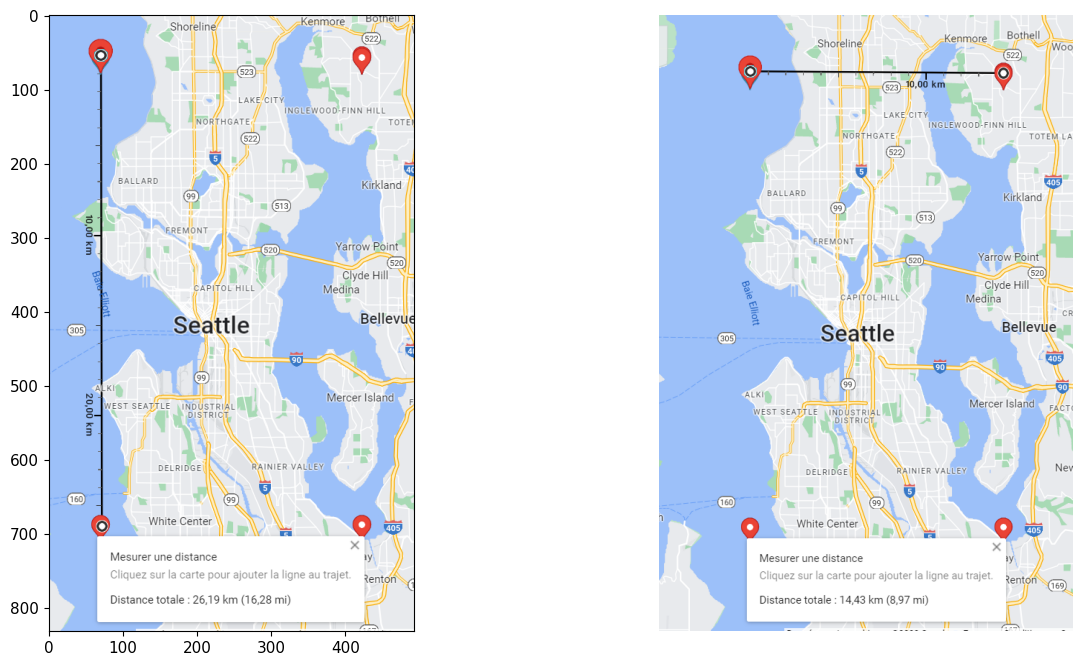

In [98]:
plt.rcParams['figure.figsize'] = [15, 8]
image_list = ["studied-zone-height.png", "studied-zone-width.png"]
DisplotData.display_external_images(image_list)

La zone d'étude mesure 26 km sur 14.5, le climat ne devrait pas être très différent d'un point à l'autre. 

The study area measures 26 km by 14.5 km, the climate should not be very different from one point to another.

Dans `df_2015`, la `'Location'` contient :

In `df_2015`, the `'Location'` contains:

In [99]:
df_2015.loc[22, 'Location']

'{\'latitude\': \'47.54570136\', \'longitude\': \'-122.2685843\', \'human_address\': \'{"address": "5101 S GRAHAM ST", "city": "SEATTLE", "state": "WA", "zip": "98118"}\'}'

In [100]:
def get_latitude(row):
    lat = row.split("'")[3]
    return lat

def get_longitude(row):
    lgt = row.split("'")[7]
    return lgt

df_2015['Latitude'] = df_2015['Location'].apply(get_latitude)
df_2015['Longitude'] = df_2015['Location'].apply(get_longitude)

L'adresse humaine n'est pas non plus utile au problème de régression :

The human address is also not useful to the regression problem:

In [101]:
droped_cols.extend(['Location']) # df_2015
droped_cols.extend(['Address']) # df_2016

Les codes ZIP ont légèrement changé de nom :

The ZIP codes have had a slight name change:

In [102]:
dict_fus['Zip Codes'] = 'ZipCode'

La variable `'GHGEmissions(MetricTonsCO2e)'` dans les données de 2015 et la variable `'TotalGHGEmissions'` des données 2016 ont exactement la même définiton, unité et paramètre de calcul. Mais vérifions qu'elles ont bien le même- profil : 

The variable `'GHGEmissions(MetricTonsCO2e)'` in the 2015 data and the variable `'TotalGHGEmissions'` in the 2016 data have exactly the same definition, unit and calculation parameter. But let's check that they have the same profile:

Text(0.5, 1.0, 'Distributions of GHGEmissions(MetricTonsCO2e) and TotalGHGEmissions')

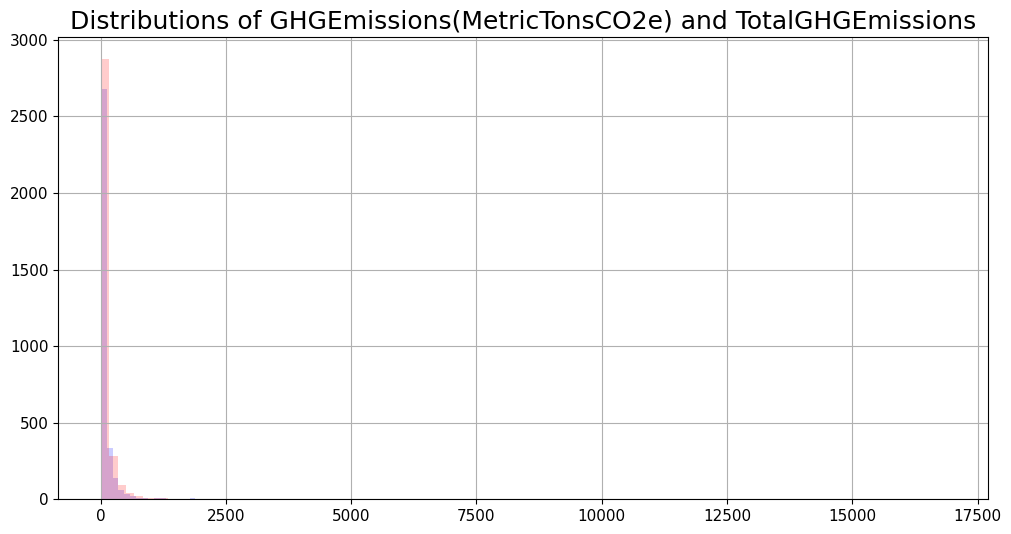

In [103]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.figure()
df_2015['GHGEmissions(MetricTonsCO2e)'].hist(color='b', bins=100, alpha=0.2)
df_2016['TotalGHGEmissions'].hist(color='r', bins=100, alpha=0.2)
plt.title('Distributions of GHGEmissions(MetricTonsCO2e) and TotalGHGEmissions')

Et les mêmes moments :

And the same moments:

In [104]:
print((df_2015['GHGEmissions(MetricTonsCO2e)'].mean(), df_2016['TotalGHGEmissions'].mean()))

(110.0941021021021, 119.72397089397089)


In [105]:
print((df_2015['GHGEmissions(MetricTonsCO2e)'].std(), df_2016['TotalGHGEmissions'].std()))

(409.4501794730603, 538.8322265068628)


On peut donc fusionner ces deux variables.

We can therefore merge these two variables.

In [106]:
dict_fus['GHGEmissions(MetricTonsCO2e)'] = 'TotalGHGEmissions'

De même : `'GHGEmissionsIntensity(kgCO2e/ft2)'` ⇔ `'GHGEmissionsIntensity'` :

Similarly: `'GHGEmissionsIntensity(kgCO2e/ft2)'` ⇔ `'GHGEmissionsIntensity'`:

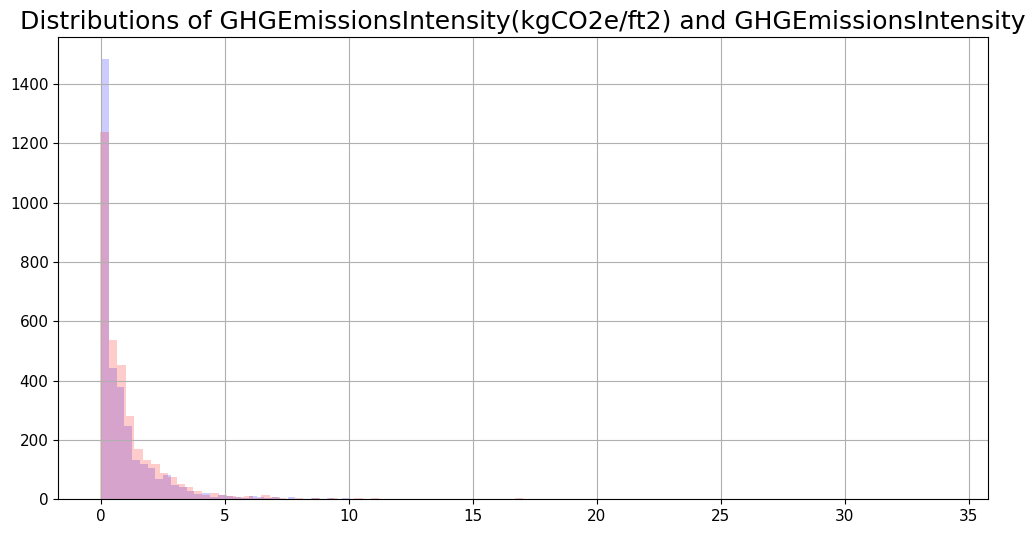

In [107]:
plt.figure()
df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'].hist(color='b',bins=100,alpha=0.2)
df_2016['GHGEmissionsIntensity'].hist(color='r',bins=100,alpha=0.2)
plt.title('Distributions of GHGEmissionsIntensity(kgCO2e/ft2) and GHGEmissionsIntensity');

In [108]:
print((df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'].mean(), df_2016['GHGEmissionsIntensity'].mean()))

(0.9853393393393393, 1.175916245916246)


In [109]:
print((df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'].std(), df_2016['GHGEmissionsIntensity'].std()))

(1.6371718086243117, 1.8214517879100534)


On peut donc fusionner ces 2 variables.

We can therefore merge these 2 variables.

In [110]:
dict_fus['GHGEmissionsIntensity(kgCO2e/ft2)'] = 'GHGEmissionsIntensity'

Par contre, la variable `'OtherFuelUse(kBtu)'` semble avoir été abandonnée en 2016 : pas de comptage séparé des autres sources d'énergie que l'électricité, la vapeur et le gaz.

On the other hand, the variable `'OtherFuelUse(kBtu)'` seems to have been abandoned in 2016: no separate metering of other energy sources than electricity, steam and gas.

In [111]:
droped_cols.extend(['OtherFuelUse(kBtu)'])

### Taux de valeurs manquantes

### Rate of missing values

In [112]:
nan_rate = df_2015.isna().sum(axis=0).sort_values()/df_2015.shape[0]*100.

In [113]:
plt.rcParams['figure.figsize'] = [12, 15]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

In [114]:
seuil = nan_rate['ENERGYSTARScore']+0.1 # Histoire d'avoir une limite minimale

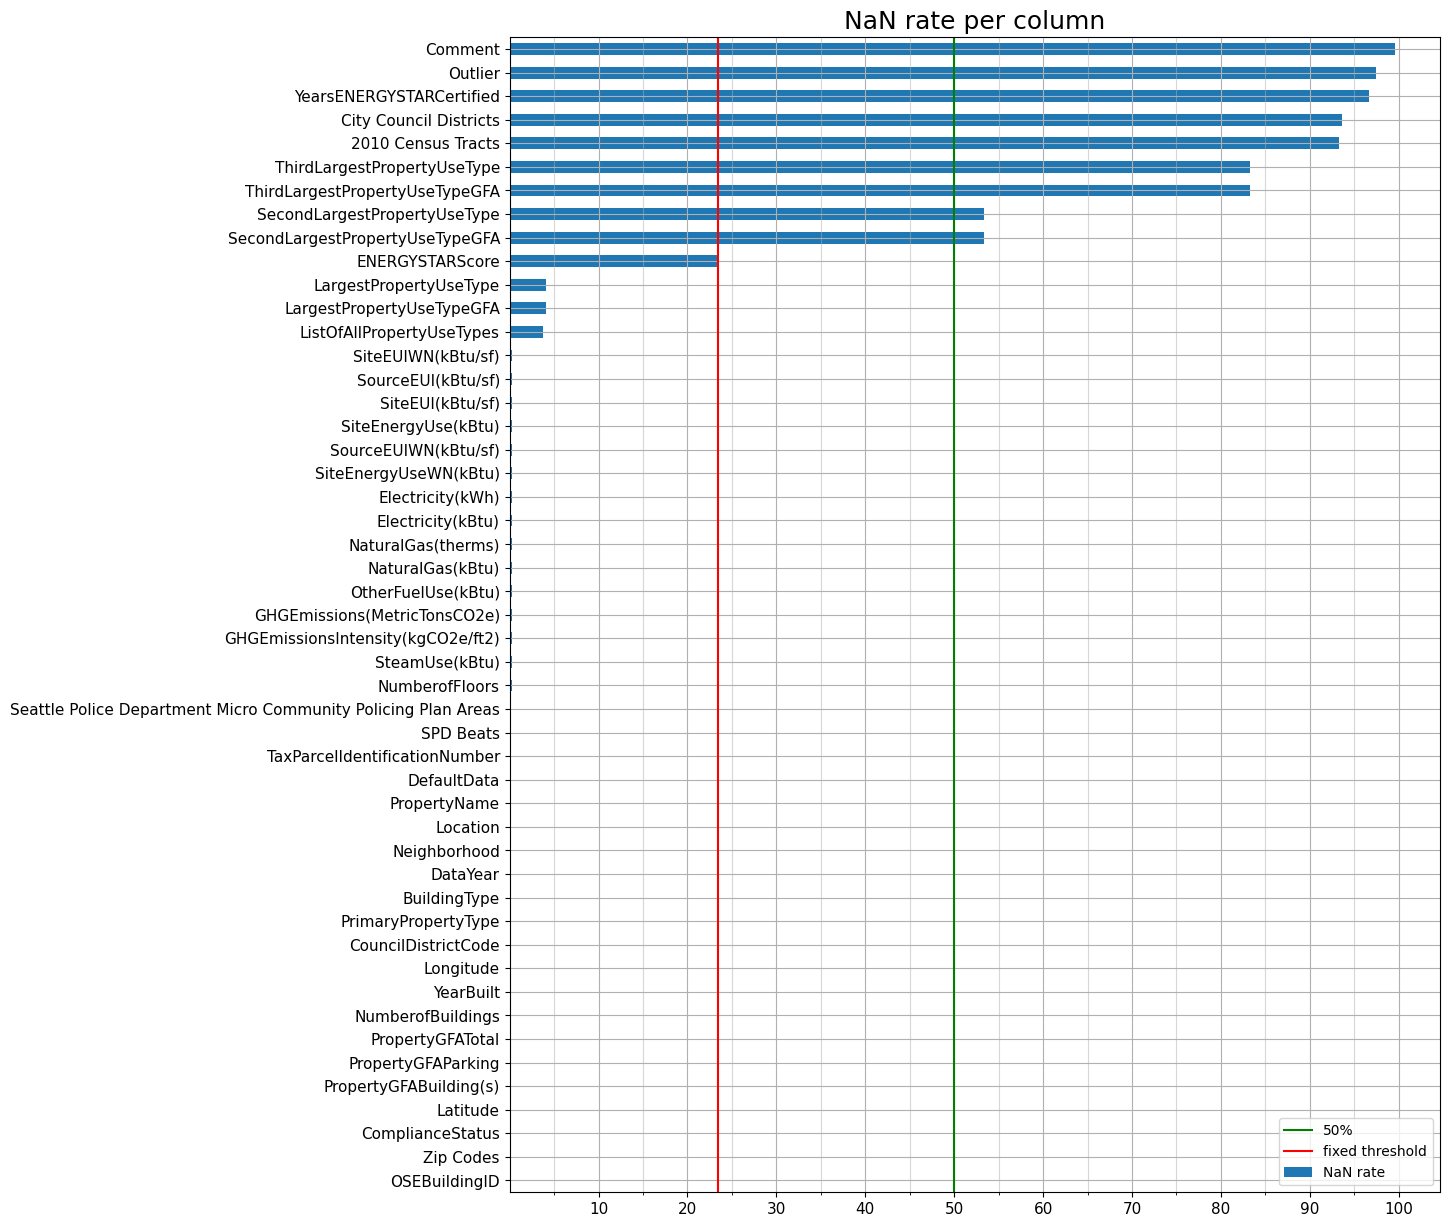

In [115]:
DisplotData.print_nan_rates(nan_rate,50.,seuil)

### Value counts

### Value counts

In [116]:
DisplotData.print_value_counts(df_2015,exclude=['OSEBuildingID'])

Legend :

Numerical variable
------------------

Categorical variable
--------------------

----------------------------------------------------------------------------------------------------


Neighborhood
------------
DOWNTOWN                 578
EAST                     444
MAGNOLIA / QUEEN ANNE    420
GREATER DUWAMISH         369
NORTHEAST                259
LAKE UNION               249
NORTHWEST                226
NORTH                    188
SOUTHWEST                165
CENTRAL                  131
BALLARD                  130
SOUTHEAST                 96
DELRIDGE                  85
Name: Neighborhood, dtype: int64


OtherFuelUse(kBtu)
------------------



LargestPropertyUseType
----------------------
Multifamily Housing                                     1598
Office                                                   479
Non-Refrigerated Warehouse                               194
K-12 School                                              136
Other                               

In [117]:
DisplotData.print_value_counts(df_2016)

Legend :

Numerical variable
------------------

Categorical variable
--------------------

----------------------------------------------------------------------------------------------------


Neighborhood
------------
DOWNTOWN                  573
EAST                      453
MAGNOLIA / QUEEN ANNE     423
GREATER DUWAMISH          375
NORTHEAST                 280
LAKE UNION                251
NORTHWEST                 210
SOUTHWEST                 166
NORTH                     145
BALLARD                   126
CENTRAL                   107
SOUTHEAST                  95
DELRIDGE                   80
North                      42
Central                    27
Northwest                  11
Ballard                     7
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: Neighborhood, dtype: int64


LargestPropertyUseType
----------------------
Multifamily Housing                                     1667
Office                                                   498
Non-Re

### Sélection (suite) des premières variables de travail

### Selection (continued) of the first working variables

On peut éliminer les variables exprimées dans une autre unité qu'une autre variable :
- `'Electricity(kWh)`, puisque l'on a `'Electricity(kBtu)'`
- `'NaturalGas(therms)'` : puisque l'on a `'NaturalGas(kBtu)'`

Variables expressed in a unit other than another variable can be eliminated:
- `'Electricity(kWh)`, since we have `'Electricity(kBtu)'`
- `'NaturalGas(therms)'`: since we have `'NaturalGas(kBtu)'`

In [118]:
droped_cols.extend(['Electricity(kWh)','NaturalGas(therms)'])

**`DataYear`**

**`DataYear`**

Vérifions que les datasets contiennent des années cohérentes : 

Let's check that the datasets contain consistent years:

In [119]:
df_2015['DataYear'].unique()

array([2015], dtype=int64)

In [120]:
df_2016['DataYear'].unique()

array([2016], dtype=int64)

Pas de mauvaise surprise, mais pas sûr que la variable année `'DataYear'` apporte une information avec le peu d'étendue entre les valeurs à notre disposition. L'année de construction sera plus porteuse d'information.

No bad surprise, but not sure that the `'DataYear'` year variable provides information with the small range between the values ​​at our disposal. The year of construction will be more informative.

In [121]:
droped_cols.extend(['DataYear'])

**`Outlier`**

**`Outlier`**

L'information `'Outlier'` est intéressante : elle permet de les éliminer du dataset ! Puis d'éliminer cette variable.
On a deux niveaux : `'Low outlier'` et `'High Outlier'`. On se permet de les éliminer.

The `'Outlier'` information is interesting: it allows them to be eliminated from the dataset! Then eliminate this variable.
There are two levels: `'Low outlier'` and `'High Outlier'`. We allow ourselves to eliminate them.

In [122]:
df_2015['Outlier'].value_counts()

High Outlier    46
Low Outlier     38
Name: Outlier, dtype: int64

In [123]:
df_2016['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

**`'BuildingType'` et `'PrimaryPropertyType'`**

**`'BuildingType'` and `'PrimaryPropertyType'`**

`'BuildingType'` et `'PrimaryPropertyType'` semblent caractériser les bâtiments avec peu de valeurs : 

`'BuildingType'` and `'PrimaryPropertyType'` seem to characterize buildings with few values:

In [124]:
len(df_2015['BuildingType'].value_counts())

7

In [125]:
len(df_2015['PrimaryPropertyType'].value_counts())

27

**`'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA'`**

**`'SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA'`**

Pourraient être utile, mais on un taux de NaN plus important que `'LargestPropertyUseType'` :

Might be useful, but we have a higher NaN rate than `'LargestPropertyUseType'`:

In [126]:
nan_rate['LargestPropertyUseType'],nan_rate['LargestPropertyUseTypeGFA']

(4.07185628742515, 4.07185628742515)

In [127]:
nan_rate['SecondLargestPropertyUseType'],nan_rate['SecondLargestPropertyUseTypeGFA']

(53.32335329341318, 53.32335329341318)

In [128]:
nan_rate['ThirdLargestPropertyUseType'],nan_rate['ThirdLargestPropertyUseTypeGFA']

(83.23353293413174, 83.23353293413174)

Imputer une valeur vraisemblable pour les variables :
```
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA'
```
peut être une bonne idée, d'autant qu'elles contiennent des types d'usage influançant la consommation énergétique, comme les Data Center :

Impute a plausible value for the variables:
```
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA'
```
can be a good idea, especially since they contain types of use that influence energy consumption, such as Data Centers:

In [129]:
df_2016.loc[(df_2016['ListOfAllPropertyUseTypes'].notna()) & (df_2016['ListOfAllPropertyUseTypes'].str.contains('Data'))].head(10)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
15,21,2016,Nonresidential COS,Other,The Seattle Public Library - Central Library,1000 Fourth Avenue,Seattle,WA,98154.0,0942000275,7,DOWNTOWN,47.60649,-122.33297,2004,1.0,11,412000,57000,355000,"Data Center, Library, Parking",Library,364913.0,Parking,49000.0,Data Center,1074.0,NaN,NaN,50.799999,51.099998,155.600006,156.000000,18588860.00,18706912.00,737559.5,5231916.00,17851297.0,0.00000,0.0,False,NaN,Compliant,NaN,181.38,0.44
44,57,2016,NonResidential,Large Office,5th and Pine,413 Pine Street,Seattle,WA,98101.0,1975700200,7,DOWNTOWN,47.61130,-122.33659,1973,1.0,5,168115,0,168115,"Data Center, Office, Retail Store",Office,103362.0,Retail Store,65676.0,Data Center,493.0,2016,78.0,56.299999,56.299999,176.600006,176.600006,9536161.00,9536161.00,0.0,2794888.75,9536160.0,0.00000,0.0,False,NaN,Compliant,NaN,66.48,0.40
65,96,2016,NonResidential,Mixed Use Property,Central Seattle,921 Terry Ave.,Seattle,WA,98104.0,1979200290,3,EAST,47.60845,-122.32637,1983,1.0,6,99780,9341,90439,"Data Center, Medical Office, Non-Refrigerated ...",Medical Office,40174.0,Parking,20868.0,Office,17020.0,NaN,NaN,204.500000,207.300003,505.799988,504.299988,15473117.00,15684371.00,5327802.5,2973421.25,10145313.0,0.00000,0.0,False,NaN,Compliant,NaN,481.97,4.83
76,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 Mercer St,Seattle,WA,98109.0,1988200705,7,MAGNOLIA / QUEEN ANNE,47.62391,-122.34837,1986,0.0,2,66240,2352,63888,"Data Center, Distribution Center, Office, Park...",Office,45900.0,Data Center,5181.0,Distribution Center,4551.0,NaN,NaN,74.900002,75.400002,235.199997,236.600006,4166306.25,4192107.75,0.0,1221074.25,4166305.0,0.00000,0.0,False,NaN,Compliant,NaN,29.04,0.44
106,173,2016,NonResidential,Small- and Mid-Sized Office,Seattle Children's Hospital 70th/Sand Point Wa...,6901Sand Point Way NE,Seattle,WA,98115.0,6418100005,4,NORTHEAST,47.67828,-122.26456,2002,1.0,2,96300,0,96300,"Data Center, Office",Office,92300.0,Data Center,4944.0,NaN,NaN,NaN,NaN,167.800003,167.399994,476.500000,471.100006,16319835.00,16274449.00,0.0,4095456.00,13973696.0,23461.37109,2346137.0,False,NaN,Compliant,NaN,222.02,2.31
149,238,2016,Nonresidential COS,Small- and Mid-Sized Office,North Service Center,1300 N 97th ST,Seattle,WA,98103.0,4310701070,5,NORTHWEST,47.70044,-122.34136,1957,1.0,2,91130,0,91130,"Data Center, Distribution Center, Office, Othe...",Office,57968.0,Distribution Center,32881.0,Parking,11850.0,NaN,NaN,100.500000,106.099998,262.700012,272.200012,9472358.00,10005492.00,0.0,2079127.75,7093984.0,23783.73047,2378373.0,False,NaN,Compliant,NaN,175.77,1.93
156,247,2016,Nonresidential COS,Distribution Center,SCL SSC Building A,3613 4th Ave S,Seattle,WA,98134.0,7666205660,2,GREATER DUWAMISH,47.57199,-122.32811,1924,1.0,2,179161,0,179161,"Data Center, Distribution Center, Office, Other",Distribution Center,117476.0,Office,37321.0,Other,25543.0,NaN,NaN,52.200001,56.299999,156.300003,167.600006,9436408.00,10168523.00,0.0,2570956.75,8772104.0,6643.02002,664302.0,False,NaN,Compliant,NaN,96.43,0.54
226,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,

In [130]:
df_2016.loc[(df_2016['SecondLargestPropertyUseType'].notna()) & (df_2016['SecondLargestPropertyUseType'].str.contains('Data'))].head(10)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
76,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 Mercer St,Seattle,WA,98109.0,1988200705,7,MAGNOLIA / QUEEN ANNE,47.62391,-122.34837,1986,0.0,2,66240,2352,63888,"Data Center, Distribution Center, Office, Park...",Office,45900.0,Data Center,5181.0,Distribution Center,4551.0,NaN,NaN,74.900002,75.400002,235.199997,236.600006,4166306.25,4192107.75,0.0,1.221074e+06,4166305.0,0.000000,0.0,False,NaN,Compliant,NaN,29.04,0.44
106,173,2016,NonResidential,Small- and Mid-Sized Office,Seattle Children's Hospital 70th/Sand Point Wa...,6901Sand Point Way NE,Seattle,WA,98115.0,6418100005,4,NORTHEAST,47.67828,-122.26456,2002,1.0,2,96300,0,96300,"Data Center, Office",Office,92300.0,Data Center,4944.0,NaN,NaN,NaN,NaN,167.800003,167.399994,476.500000,471.100006,16319835.00,16274449.00,0.0,4.095456e+06,13973696.0,23461.371090,2346137.0,False,NaN,Compliant,NaN,222.02,2.31
226,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,"Data Center, Office, Parking",Office,99890.0,Data Center,39336.0,Parking,25000.0,NaN,NaN,297.399994,299.200012,909.599976,911.500000,41399504.00,41650404.00,0.0,1.166315e+07,39794668.0,16048.309570,1604831.0,False,NaN,Non-Compliant,High outlier,362.66,2.10
309,440,2016,NonResidential,Mixed Use Property,Fisher Plaza - West Building,100 4th Ave N,Seattle,WA,98109.0,1991200170,7,LAKE UNION,47.61915,-122.34857,2001,1.0,6,213834,104922,108912,"Data Center, Financial Office, Office, Other, ...",Parking,104922.0,Data Center,54385.0,Office,37721.0,NaN,100.0,707.299988,707.299988,2217.800049,2217.800049,75073888.00,75073888.00,0.0,2.195702e+07,74917352.0,1565.250000,156525.0,False,NaN,Compliant,NaN,530.59,2.48
328,465,2016,NonResidential,Large Office,1000 Denny Building,1000 Denny Way,Seattle,WA,98109.0,2693100010,7,LAKE UNION,47.61907,-122.33651,1929,1.0,8,287819,0,287819,"Data Center, Office, Other, Restaurant",Office,155985.0,Data Center,88350.0,Other,15630.0,NaN,NaN,176.000000,174.600006,550.700012,545.900024,48406556.00,48037000.00,0.0,1.411344e+07,48155040.0,2515.109863,251511.0,False,NaN,Compliant,NaN,349.07,1.21
333,469,2016,NonResidential,Laboratory,Rosen Building - SEDO,960 Republican St.,Seattle,WA,98109.0,1983200160,7,LAKE UNION,47.62348,-122.33743,1928,1.0,3,55200,0,55200,"Data Center, Laboratory",Laboratory,54880.0,Data Center,320.0,NaN,NaN,NaN,NaN,210.000000,218.699997,504.500000,509.000000,11594121.00,12072969.00,0.0,2.198235e+06,7500378.0,40937.421880,4093742.0,False,NaN,Compliant,NaN,269.71,4.89
471,633,2016,NonResidential,Large Office,83 S KING ST BLDG (ID633),83 S KING ST,Seattle,WA,98104.0,7666206895,2,DOWNTOWN,47.59806,-122.33475,1904,1.0,7,184322,0,184322,"Data Center, Office",Office,183916.0,Data Center,406.0,NaN,NaN,NaN,81.0,52.700001,52.700001,165.600006,165.600006,9722890.00,9722890.00,0.0,2.849616e+06,9722889.0,0.000000,0.0,False,NaN,Compliant,NaN,67.78,0.37
489,658,2016,NonResidential,Large Office,505 Union Station - SEDO,505 5th Ave. South,Seattle,WA,98104.0,8809700020,2,DOWNTOWN,47.59794,-122.32767,2000,1.0,11,312512,0,312512,"Data Center, Office, Restaurant",Office,303312.0,

In [131]:
df_2016.loc[(df_2016['ThirdLargestPropertyUseType'].notna()) & (df_2016['ThirdLargestPropertyUseType'].str.contains('Data'))].head(10)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
15,21,2016,Nonresidential COS,Other,The Seattle Public Library - Central Library,1000 Fourth Avenue,Seattle,WA,98154.0,0942000275,7,DOWNTOWN,47.60649,-122.33297,2004,1.0,11,412000,57000,355000,"Data Center, Library, Parking",Library,364913.0,Parking,49000.0,Data Center,1074.0,NaN,NaN,50.799999,51.099998,155.600006,156.000000,18588860.0,18706912.0,737559.5,5.231916e+06,17851297.0,0.000000,0.0,False,NaN,Compliant,NaN,181.38,0.44
44,57,2016,NonResidential,Large Office,5th and Pine,413 Pine Street,Seattle,WA,98101.0,1975700200,7,DOWNTOWN,47.61130,-122.33659,1973,1.0,5,168115,0,168115,"Data Center, Office, Retail Store",Office,103362.0,Retail Store,65676.0,Data Center,493.0,2016,78.0,56.299999,56.299999,176.600006,176.600006,9536161.0,9536161.0,0.0,2.794889e+06,9536160.0,0.000000,0.0,False,NaN,Compliant,NaN,66.48,0.40
228,352,2016,NonResidential,Large Office,Abraham Lincoln Building (Wallysons Inc),1110 Third Avenue,Seattle,WA,98101.0,0942000140,7,DOWNTOWN,47.60671,-122.33456,1972,1.0,14,186768,23775,162993,"Data Center, Office, Parking",Office,182540.0,Parking,33671.0,Data Center,240.0,201620142012,95.0,52.700001,53.900002,142.800003,143.100006,9641043.0,9843217.0,2154977.5,2.194040e+06,7486064.0,0.000000,0.0,False,NaN,Compliant,NaN,218.53,1.17
234,358,2016,Nonresidential COS,Large Office,Justice Center,610 5th Ave,Seattle,WA,98104.0,0942000750,3,DOWNTOWN,47.60421,-122.32919,2001,1.0,14,310490,0,310490,"Data Center, Office, Other",Office,269284.0,Other,28394.0,Data Center,600.0,NaN,NaN,71.000000,73.599998,187.500000,189.500000,21169502.0,21960822.0,0.0,4.725684e+06,16124036.0,50454.648440,5045465.0,False,NaN,Compliant,NaN,380.37,1.23
308,439,2016,NonResidential,Mixed Use Property,Fisher Plaza - East Building,140 4th Ave N,Seattle,WA,98109.0,1991200150,7,LAKE UNION,47.61915,-122.34857,2001,1.0,6,378443,177660,200783,"Data Center, Office, Parking, Performing Arts,...",Parking,164332.0,Office,108781.0,Data Center,54184.0,NaN,100.0,283.700012,283.700012,874.099976,874.099976,55073120.0,55073120.0,0.0,1.568186e+07,53506520.0,15665.939450,1566594.0,False,NaN,Compliant,NaN,456.22,1.21
371,523,2016,NonResidential,Large Office,Adobe Seattle,801 N 34th,Seattle,WA,98103.0,1973200385,6,LAKE UNION,47.64822,-122.34848,1999,1.0,3,280957,114829,166128,"Data Center, Office, Parking, Restaurant",Office,152579.0,Parking,93893.0,Data Center,7500.0,2016201520142013201220112010,96.0,68.699997,68.699997,211.300003,211.300003,11325513.0,11325513.0,0.0,3.219974e+06,10986553.0,3366.104004,336610.0,False,NaN,Compliant,NaN,94.47,0.34
411,570,2016,NonResidential,Small- and Mid-Sized Office,Northwest Building,2323 Eastlake Ave E,Seattle,WA,98102.0,2902201000,4,LAKE UNION,47.64037,-122.32626,1978,1.0,4,85385,31210,54175,"Data Center, Office, Parking",Office,50235.0,Parking,25525.0,Data Center,2875.0,NaN,NaN,91.400002,92.500000,287.000000,290.299988,4855036.5,4910799.5,0.0,1.422930e+06,4855036.0,0.000000,0.0,False,NaN,Compliant,NaN,33.85,0.40
516,703,2016,NonResidential,Large Office,501 Elliott Ave West,501 Elliot Ave West,Seattle,WA,98119.0,7666202080,7,MAGNOLIA / QUEEN ANNE,47.62302,-122.36476,2000,1.0,4,165111,55000,110111,"Data Center, Office, Parking",Office,104667.

Si on veut conserver les lignes :
```
'SecondLargestPropertyUseType',
'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType',
'ThirdLargestPropertyUseTypeGFA'
```
on peut envisager d'imputer de différentes manières (voir plus loin).

If we want to keep the rows:
```
'SecondLargestPropertyUseType',
'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType',
'ThirdLargestPropertyUseTypeGFA'
```
imputation can be envisaged in different ways (see below).

**`'PrimaryPropertyType'`, `'LargestPropertyUseType'`**

**`'PrimaryPropertyType'`, `'LargestPropertyUseType'`**

In [132]:
df_2015[['PrimaryPropertyType','LargestPropertyUseType']].head(50)

,PrimaryPropertyType,LargestPropertyUseType
0,Hotel,Hotel
1,Hotel,Hotel
2,Hotel,Hotel
3,Hotel,Hotel
4,Hotel,Hotel
5,Other,Police Station
6,Hotel,Hotel
7,Other,Other - Entertainment/Public Assembly
8,Hotel,Hotel
9,Mid-Rise Multifamily,Multifamily Housing


Les variables `'PrimaryPropertyType'` et `'LargestPropertyUseType'` semblent extrêmement proches, mais `'PrimaryPropertyType'` documente mieux les Office que `'LargestPropertyUseType'` (`'Small- and Mid-Sized Office'`, `'Large Office'`), contre `'Office'` et les Multifamily (`'Low-Rise Multifamily'`, `'Mid-Rise Multifamily'`), mais moins bien les Other (`'Parking'`, `'Manufacturing/Industrial Plant'`, `'Data Center'` dans la variable `'LargestPropertyUseType'`). 
Comme la distinction entre les Other est plus importante qu'entre les Office, on gardera **`'LargestPropertyUseType'`** entre les deux.
Choix confirmé par `'Warehouse'` | `'Non-Refrigerated Warehouse'` !

The `'PrimaryPropertyType'` and `'LargestPropertyUseType'` variables seem extremely close, but `'PrimaryPropertyType'` documents Offices better than `'LargestPropertyUseType'` (`'Small- and Mid-Sized Office'`, `'Large Office '`), against `'Office'` and Multifamily (`'Low-Rise Multifamily'`, `'Mid-Rise Multifamily'`), but less well Other (`'Parking'`, `'Manufacturing/Industrial Plant'`, `'Data Center'` in the variable `'LargestPropertyUseType'`).
As the distinction between Other is more important than between Office, we will keep **`'LargestPropertyUseType'`** between the two.
Choice confirmed by `'Warehouse'` | `'Non-Refrigerated Warehouse'`!

**`YearBuilt`**

**`YearBuilt`**

In [133]:
print(f"{df_2015['YearBuilt'].min()} ; {df_2015['YearBuilt'].max()}")

1900 ; 2015


In [134]:
print(f"{df_2016['YearBuilt'].min()} ; {df_2016['YearBuilt'].max()}")

1900 ; 2015


**`DefaultData`**

**`DefaultData`**

La variable `'DefaultData'` indique que les renseignements ont été saisis en mode nawac ou presque nous permet d'écarter les propriétés pas bien renseignées. Elles représentent :

The variable `'DefaultData'` indicates that the information has been entered in nawac mode or almost allows us to discard properties that are not well informed. They represent :

**`ComplianceStatus`**

**`ComplianceStatus`**

Mesurons la taille des données considérées comme non 'Compliant':

Let's measure the size of data considered non-Compliant:

In [135]:
a = df_2015.loc[df_2015['ComplianceStatus']=='Compliant'].shape[0]
b = df_2015.shape[0]
(b-a)/(b)

0.0008982035928143712

In [136]:
a = df_2016.loc[df_2016['ComplianceStatus']=='Compliant'].shape[0]
b = df_2016.shape[0]
(b-a)/(b)

0.04887440758293839

Moins de 5%. On supprimera ces lignes !

Less than 5%. We will delete these lines!

**`'CouncilDistrictCode'`, `'Neighborhood'`**

**`'CouncilDistrictCode'`, `'Neighborhood'`**

In [137]:
df_2015['CouncilDistrictCode'].tail(10)

3330    5
3331    3
3332    3
3333    7
3334    7
3335    2
3336    4
3337    7
3338    4
3339    4
Name: CouncilDistrictCode, dtype: int64

In [138]:
df_2015['Neighborhood'].tail(10)

3330                    NORTH
3331                     EAST
3332                     EAST
3333               LAKE UNION
3334    MAGNOLIA / QUEEN ANNE
3335                 DOWNTOWN
3336                NORTHEAST
3337                 DOWNTOWN
3338                NORTHEAST
3339                NORTHEAST
Name: Neighborhood, dtype: object

On conservera la notion de **Neighborhood**, au moins dans les études de corrélation, car les quartiers peuvent différer en émissions de GES :

We will retain the notion of **Neighborhood**, at least in correlation studies, because neighborhoods can differ in terms of GHG emissions:

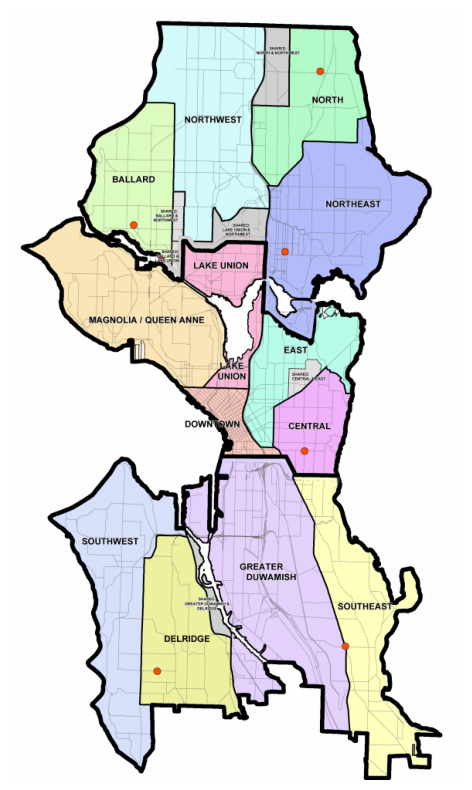

Source : https://fr.wikipedia.org/wiki/Liste_des_quartiers_de_Seattle


In [409]:
plt.rcParams['figure.figsize'] = [10, 10]
image_list = ["Map_of_Seattle_divided_by_districts.png"]
DisplotData.display_external_images(image_list)
print('Source : https://fr.wikipedia.org/wiki/Liste_des_quartiers_de_Seattle')

On fera plus loin une étude bivariée des moyennes d'intensité d'émission par quartier, pour s'en convaincre.

A bivariate study of the emission intensity averages by district will be carried out later, to be convinced of this.

**`ListOfAllPropertyUseTypes`**

**`ListOfAllPropertyUseTypes`**

La variable `'ListOfAllPropertyUseTypes'` contient les destinations de l'immeuble, mais **dans l'ordre alphabétique**, donc on perd la notion de destination principale (en surface de plancher), secondaire etc, recensées par les variables `'LargestPropertyUseType'`, `'SecondLargestPropertyUseType'` et `'ThirdLargestPropertyUseType'`.
Le problème est que ces dernières variables ont un taux de valeur manquantes très élevé :

The `'ListOfAllPropertyUseTypes'' variable contains the destinations of the building, but **in alphabetical order**, so we lose the notion of main destination (in floor area), secondary etc, listed by the `'LargestPropertyUseType'`, `'SecondLargestPropertyUseType'` and `'ThirdLargestPropertyUseType'` variables.
The problem is that these last variables have a very high rate of missing values:

In [140]:
nan_rate[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']]

LargestPropertyUseType           4.071856
SecondLargestPropertyUseType    53.323353
ThirdLargestPropertyUseType     83.233533
dtype: float64

In [141]:
nan_rate[['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']]

LargestPropertyUseTypeGFA           4.071856
SecondLargestPropertyUseTypeGFA    53.323353
ThirdLargestPropertyUseTypeGFA     83.233533
dtype: float64

**Idées :**
- On splittera les valeurs de `'ListOfAllPropertyUseTypes'` (séparées par `,`) dans des nouvelles colonnes, pour conserver les informations sur les types.
- On peut conserver `'LargestPropertyUseType'`, `'LargestPropertyUseTypeGFA'` et supprimer les lignes avec NaN.
- Par contre on devra renoncer à : `'SecondLargestPropertyUseType'`, `'ThirdLargestPropertyUseType'`
`'SecondLargestPropertyUseTypeGFA'`, `'ThirdLargestPropertyUseTypeGFA'`, ou bien **imputer** ces variables (algo de ML ?).

Pour le moment, gardons simplement `'ListOfAllPropertyUseTypes'`, `'LargestPropertyUseType'`, `'LargestPropertyUseTypeGFA'` et jetons :
```
'SecondLargestPropertyUseType'
'ThirdLargestPropertyUseType'
'SecondLargestPropertyUseTypeGFA'
'ThirdLargestPropertyUseTypeGFA'
```

**A jeter également :**
- `'OSEBuildingID'` : ID inutile pour la régression (supprimé après la fusion des doublons)
- `'PropertyName'` : n'apporte pas d'information
- `'City'` : que du `'Seattle'`
- `'State'` : que du `'WA'`
- `'TaxParcelIdentificationNumber'` : n'apporte pas  d'infos
- `'YearsENERGYSTARCertified'` : cette variable n'est pas le score mais le nombre d'années de certification, donc inutile
- `'ComplianceStatus'` : je propose de supprimer les lignes qui ont une autre valeur que `'Compliant'` (<5%), puis de supprimer cette variable.
- `'DefaultData'` : redondant avec `'ComplianceStatus'`
- `'Comment'` (2015), `'Comments'` (2016) : pas utile pour l'algorithme de régression
- `'2010 Census Tracts'` (2015) : pas utile et peu renseigné
- `'Seattle Police Department Micro Community Policing Plan Areas'` : voilà
- `'SPD Beats'` : idem
- `'City Council Districts'` (2015) : pas dans 2016 !

**Ideas:**
- We will split the values ​​of `'ListOfAllPropertyUseTypes'` (separated by `,`) in new columns, to keep the information on the types.
- We can keep `'LargestPropertyUseType'`, `'LargestPropertyUseTypeGFA'` and delete the lines with NaN.
- On the other hand, we will have to give up: `'SecondLargestPropertyUseType'`, `'ThirdLargestPropertyUseType'`
`'SecondLargestPropertyUseTypeGFA'`, `'ThirdLargestPropertyUseTypeGFA'`, or **impute** these variables (ML algo?).

For now, let's just keep `'ListOfAllPropertyUseTypes'`, `'LargestPropertyUseType'`, `'LargestPropertyUseTypeGFA'` and tokens:
```
'SecondLargestPropertyUseType'
'ThirdLargestPropertyUseType'
'SecondLargestPropertyUseTypeGFA'
'ThirdLargestPropertyUseTypeGFA'
```

**Also throw away:**
- `'OSEBuildingID'`: useless ID for regression (removed after merging duplicates)
- `'PropertyName'`: does not provide information
- `'City'`: only `'Seattle'`
- `'State'`: only `'WA'`
- `'TaxParcelIdentificationNumber'`: does not provide information
- `'YearsENERGYSTARCertified'`: this variable is not the score but the number of years of certification, therefore useless
- `'ComplianceStatus'`: I propose to delete the lines which have a value other than `'Compliant'` (<5%), then to delete this variable.
- `'DefaultData'`: redundant with `'ComplianceStatus'`
- `'Comment'` (2015), `'Comments'` (2016): not useful for the regression algorithm
- `'2010 Census Tracts'` (2015): not useful and poorly informed
- ``Seattle Police Department Micro Community Policing Plan Areas'`: here it is
- `'SPD Beats'`: same
- `'City Council Districts'` (2015): not in 2016!

In [142]:
droped_cols.extend(['PropertyName',
                    'City',
                    'State',
                    'TaxParcelIdentificationNumber',
                    'YearsENERGYSTARCertified',
                    'DefaultData',
                    'Comment',
                    'Comments',
                    '2010 Census Tracts',
                    'Seattle Police Department Micro Community Policing Plan Areas',
                    'SPD Beats',
                    'City Council Districts'])

**A étudier :**
- `'ZipCode'` : car la zone portée par 'ZipCode' pourrait avoir une influence (ex : Porchefontaine (78000), quartier résidentiel de Versailles doit plus émettre que Trappes (78190), pourtant éloignés de 12 km)
- `'CouncilDistrictCode'` : même idée
- `'Neighborhood'` : (quartier) peut-être encore plus déterminant sur les émissions que les deux codes précédents
- `'YearBuilt'` : aura très certainenemnt une influence sur les émissions (1900, 1910, ..., 2015)
- `'NumberofBuildings'` : Voir si la surface de plancher `'PropertyGFATotal'` ne suffit pas
- `'NumberofFloors'` : idem
- `'ListOfAllPropertyUseTypes'` : possiblement redondant avec `'LargestPropertyUseType'`, `'SecondLargestPropertyUseType'`, `'ThirdLargestPropertyUseType'`
- `'SiteEUI(kBtu/sf)'` versus `'SiteEUIWN(kBtu/sf)'`
- `'SourceEUI(kBtu/sf)'`versus `'SourceEUIWN(kBtu/sf)'`
- `'SiteEnergyUse(kBtu)'` versus `'SiteEnergyUseWN(kBtu)'`
- `'ENERGYSTARScore'` : l'énoncé du projet demande à vérifier sa pertinence, on la supprime de la régression mais on étudiera sa corrélation avec l'énergie/émissions dans une étude à part


**A encoder :**
- `'BuildingType'` : OneHot car pas de hiérarchie
- `'PrimaryPropertyType'` : OneHot car pas de hiérarchie
- TBC

**To be studied:**
- `'ZipCode'`: because the area covered by 'ZipCode' could have an influence (eg Porchefontaine (78000), residential district of Versailles must emit more than Trappes (78190), yet 12 km away)
- `'CouncilDistrictCode'`: same idea
- `'Neighborhood'`: (neighbourhood) perhaps even more decisive on emissions than the two previous codes
- `'YearBuilt'`: will definitely have an influence on emissions (1900, 1910, ..., 2015)
- `'NumberofBuildings'`: See if floor area `'PropertyGFATotal'` is not enough
- `'NumberofFloors'`: same
- `'ListOfAllPropertyUseTypes'`: ​​possibly redundant with `'LargestPropertyUseType'`, `'SecondLargestPropertyUseType'`, `'ThirdLargestPropertyUseType'`
- `'SiteEUI(kBtu/sf)'` versus `'SiteEUIWN(kBtu/sf)'`
- `'SourceEUI(kBtu/sf)'` versus `'SourceEUIWN(kBtu/sf)'`
- `'SiteEnergyUse(kBtu)'` versus `'SiteEnergyUseWN(kBtu)'`
- `'ENERGYSTARScore'`: the project statement asks to check its relevance, we remove it from the regression but we will study its correlation with energy/emissions in a separate study


**To be encoded:**
- `'BuildingType'`: OneHot because no hierarchy
- `'PrimaryPropertyType'`: OneHot because no hierarchy
-TBC

### Renommage, suppression des colonnes et fusion des datasets

### Renaming, deleting columns and merging datasets

In [143]:
df_2015.rename(columns=dict_fus, inplace=True)

In [144]:
df_all = pd.concat([df_2015,df_2016],axis=0,ignore_index=True)

In [145]:
df_all.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,ZipCode,Comments
count,6716.000000,6716.00000,6716.000000,6716.000000,6708.000000,6708.000000,6.716000e+03,6716.000000,6.716000e+03,6.560000e+03,3238.000000,1156.000000,5093.000000,6699.000000,6700.000000,6697.000000,6697.000000,6.701000e+03,6.700000e+03,6.697000e+03,6.697000e+03,6.697000e+03,6.697000e+03,6.697000e+03,3.330000e+03,6697.000000,6697.000000,224.000000,3338.000000,213.000000,3338.000000,6700.000000,0.0
mean,20867.420488,2015.50268,4.445057,1968.101549,1.071407,4.695736,9.281410e+04,9519.597975,8.329450e+04,7.707936e+04,28074.100153,11262.497750,67.906342,54.182341,57.308522,133.510303,138.356802,5.194673e+06,5.240110e+06,2.625076e+05,1.052458e+06,3.591058e+06,1.311223e+04,1.311223e+06,7.142301e+03,114.935638,1.081154,123.062500,32.380168,1.347418,24.825644,58570.218060,NaN
std,11878.968174,0.50003,2.123749,33.020391,1.593505,5.476218,1.875062e+05,33868.050881,1.733470e+05,1.681617e+05,53473.984688,26287.655182,27.012124,55.101657,56.390651,135.677195,135.302508,1.813648e+07,1.500896e+07,3.704221e+06,3.659769e+06,1.248728e+07,5.685626e+04,5.685627e+06,1.962790e+05,478.876573,1.734763,5.812128,19.907567,0.477272,15.006287,39670.096871,NaN
min,1.000000,2015.00000,1.000000,1900.000000,0.000000,0.000000,1.128500e+04,-3.000000,-5.055000e+04,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,0.000000e+00,-0.800000,-0.020000,116.000000,1.000000,1.000000,1.000000,17916.000000,NaN
25%,19934.000000,2015.00000,3.000000,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.727300e+04,2.501600e+04,4993.000000,2325.000000,52.000000,27.600000,29.600000,74.000000,79.199997,9.200689e+05,9.818029e+05,0.000000e+00,1.867660e+05,6.372730e+05,0.000000e+00,0.000000e+00,0.000000e+00,9.450000,0.160000,117.000000,14.000000,1.000000,10.000000,18390.000000,NaN
50%,23064.000000,2016.00000,4.000000,1974.000000,1.000000,4.000000,4.400800e+04,0.000000,4.218500e+04,3.953000e+04,10631.000000,5039.000000,75.000000,38.000000,40.900000,95.600000,102.099998,1.791071e+06,1.926136e+06,0.000000e+00,3.422434e+05,1.167735e+06,3.051000e+03,3.051000e+05,0.000000e+00,33.180000,0.540000,123.000000,33.000000,1.000000,26.000000,98061.500000,NaN
75%,25868.250000,2016.00000,7.000000,1996.000000,1.000000,5.000000,8.943125e+04,0.000000,8.112000e+04,7.417800e+04,26462.000000,10270.000000,90.000000,60.200000,64.925001,143.900000,149.800000,4.135280e+06,4.377974e+06,0.000000e+00,8.198140e+05,2.797320e+06,1.149639e+04,1.149639e+06,0.000000e+00,91.530000,1.280000,125.500000,50.000000,2.000000,38.000000,98115.000000,NaN
max,50226.000000,2016.00000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,8.269669e+06,16870.980000,34.090000,135.000000,61.000000,2.000000,51.000000,98272.000000,NaN


In [146]:
df_all.isnull().sum().sum()

83456

In [147]:
df_all.drop(droped_cols, axis=1, inplace=True)

In [148]:
df_all.head(30)

,OSEBuildingID,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude
0,1,NonResidential,Hotel,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,3686160.0,1272388.0,249.43,2.64,Compliant,NaN,18081.0,47.61219025,-122.33799744
1,2,NonResidential,Hotel,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,3905411.0,4448985.0,263.51,2.38,Compliant,NaN,18081.0,47.61310583,-122.33335756
2,3,NonResidential,Hotel,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,49762435.0,3709900.0,2061.48,1.92,Compliant,NaN,18081.0,47.61334897,-122.33769944
3,5,NonResidential,Hotel,7,DOWNTOWN,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,2769023.0,2001894.0,1936.34,31.38,Compliant,High Outlier,18081.0,47.61421585,-122.33660889
4,8,NonResidential,Hotel,7,DOWNTOWN,1980,1.0,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,6066245.0,8763105.0,507.70,4.02,Compliant,NaN,19576.0,47.6137544,-122.3409238
5,9,Nonresidential COS,Other,7,DOWNTOWN,1999,1.0,2.0,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,135.7,146.9,313.5,321.6,12051984.0,13045258.0,0.0,7271004.0,4781283.0,304.62,2.81,Compliant,NaN,19576.0,47.6164389,-122.33676431
6,10,NonResidential,Hotel,7,DOWNTOWN,1926,1.0,11.0,83008,0,83008,Hotel,Hotel,81352.0,NaN,NaN,NaN,NaN,25.0,76.9,79.6,149.5,158.2,6252842.0,6477493.0,0.0,2679698.0,3573255.0,208.46,2.37,Compliant,NaN,18081.0,47.6141141,-122.33274086
7,11,NonResidential,Other,7,DOWNTOWN,1926,1.0,8.0,102761,0,102761,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761.0,NaN,NaN,NaN,NaN,NaN,62.5,71.8,152.2,160.4,6426022.0,7380086.0,2003108.0,4108004.0,315079.0,199.99,1.77,Compliant,NaN,18081.0,47.61290234,-122.33130949
8,12,NonResidential,Hotel,7,DOWNTOWN,1904,1.0,15.0,163984,0,163984,Hotel,Hotel,163984.0,NaN,NaN,NaN,NaN,46.0,77.0,82.9,174.6,186.8,12633744.0,13589025.0,0.0,7355649.0,5278400.0,331.61,1.83,Compliant,NaN,18379.0,47.60258934,-122.33255325
9,13,Multifamily MR (5-9),Mid-Rise Multifamily,7,DOWNTOWN,1910,1.0,6.0,63712,1496,62216,Multifamily Housing,Multifamily Housing,56132.0,NaN,NaN,NaN,NaN,2.0,81.7,92.7,178.1,190.8,4587231.0,5203458.0,1483476.0,2370050.0,733803.0,170.00,2.51,Compliant,NaN,18379.0,47.60278416,-122.33214887


### Fusion des doublons

### Merge duplicates

La variable `'OSEBuildingID'` nous permet d'identifier les bâtiments de manière unique. On conservera la dernière occurence (2016, normalement), car probablement mieux documentée.

The `'OSEBuildingID'` variable allows us to uniquely identify buildings. We will keep the last occurrence (2016, normally), because probably better documented.

In [149]:
df_all.loc[df_all[['OSEBuildingID']].duplicated(keep='last'),:].head(15) # 'last'

,OSEBuildingID,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude
0,1,NonResidential,Hotel,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,3686160.0,1272388.0,249.43,2.64,Compliant,NaN,18081.0,47.61219025,-122.33799744
1,2,NonResidential,Hotel,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,3905411.0,4448985.0,263.51,2.38,Compliant,NaN,18081.0,47.61310583,-122.33335756
2,3,NonResidential,Hotel,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,49762435.0,3709900.0,2061.48,1.92,Compliant,NaN,18081.0,47.61334897,-122.33769944
3,5,NonResidential,Hotel,7,DOWNTOWN,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,2769023.0,2001894.0,1936.34,31.38,Compliant,High Outlier,18081.0,47.61421585,-122.33660889
4,8,NonResidential,Hotel,7,DOWNTOWN,1980,1.0,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,6066245.0,8763105.0,507.70,4.02,Compliant,NaN,19576.0,47.6137544,-122.3409238
5,9,Nonresidential COS,Other,7,DOWNTOWN,1999,1.0,2.0,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,135.7,146.9,313.5,321.6,12051984.0,13045258.0,0.0,7271004.0,4781283.0,304.62,2.81,Compliant,NaN,19576.0,47.6164389,-122.33676431
6,10,NonResidential,Hotel,7,DOWNTOWN,1926,1.0,11.0,83008,0,83008,Hotel,Hotel,81352.0,NaN,NaN,NaN,NaN,25.0,76.9,79.6,149.5,158.2,6252842.0,6477493.0,0.0,2679698.0,3573255.0,208.46,2.37,Compliant,NaN,18081.0,47.6141141,-122.33274086
7,11,NonResidential,Other,7,DOWNTOWN,1926,1.0,8.0,102761,0,102761,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761.0,NaN,NaN,NaN,NaN,NaN,62.5,71.8,152.2,160.4,6426022.0,7380086.0,2003108.0,4108004.0,315079.0,199.99,1.77,Compliant,NaN,18081.0,47.61290234,-122.33130949
8,12,NonResidential,Hotel,7,DOWNTOWN,1904,1.0,15.0,163984,0,163984,Hotel,Hotel,163984.0,NaN,NaN,NaN,NaN,46.0,77.0,82.9,174.6,186.8,12633744.0,13589025.0,0.0,7355649.0,5278400.0,331.61,1.83,Compliant,NaN,18379.0,47.60258934,-122.33255325
9,13,Multifamily MR (5-9),Mid-Rise Multifamily,7,DOWNTOWN,1910,1.0,6.0,63712,1496,62216,Multifamily Housing,Multifamily Housing,56132.0,NaN,NaN,NaN,NaN,2.0,81.7,92.7,178.1,190.8,4587231.0,5203458.0,1483476.0,2370050.0,733803.0,170.00,2.51,Compliant,NaN,18379.0,47.60278416,-122.33214887


In [150]:
df_all.shape

(6716, 35)

In [151]:
df_all.drop_duplicates(subset=['OSEBuildingID'], inplace=True)

In [152]:
df_all.shape

(3432, 35)

On peut supprimer la colonne `'OSEBuildingID'`, à présent :

We can remove the column `'OSEBuildingID'`, now:

In [153]:
df_all.drop(['OSEBuildingID'],axis=1,inplace=True)

### Suppression des lignes douteuses et des colonnes qui en donnent l'info

### Remove questionable rows and columns that give this info

In [154]:
df_all.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'ComplianceStatus', 'Outlier', 'ZipCode',
       'Latitude', 'Longitude'],
      dtype='object')

In [155]:
selected = df_all.loc[df_all['ComplianceStatus']!='Compliant'].index
df_all.drop(selected,inplace=True)

In [156]:
selected = df_all.loc[df_all['Outlier'].notna()].index
df_all.drop(selected,inplace=True)

In [157]:
df_all.drop(['ComplianceStatus','Outlier'], axis=1, inplace=True)

### Suppression des lignes contenant des valeurs manquantes

### Remove rows with missing values

Dans un premier temps, on supprime les lignes avec `NaN`, sans imputation.

At first, we delete the rows with `NaN`, without imputation.

In [158]:
nan_rate = df_all.isna().sum(axis=0).sort_values()/df_all.shape[0]*100.

In [159]:
nan_rate

BuildingType                        0.000000
Latitude                            0.000000
PropertyGFABuilding(s)              0.000000
PropertyGFAParking                  0.000000
PropertyGFATotal                    0.000000
Longitude                           0.000000
YearBuilt                           0.000000
Neighborhood                        0.000000
CouncilDistrictCode                 0.000000
PrimaryPropertyType                 0.000000
NumberofBuildings                   0.000000
SiteEUI(kBtu/sf)                    0.149745
SiteEnergyUseWN(kBtu)               0.149745
SiteEnergyUse(kBtu)                 0.149745
SiteEUIWN(kBtu/sf)                  0.149745
GHGEmissionsIntensity               0.179695
TotalGHGEmissions                   0.179695
NaturalGas(kBtu)                    0.179695
Electricity(kBtu)                   0.179695
SteamUse(kBtu)                      0.179695
SourceEUI(kBtu/sf)                  0.179695
SourceEUIWN(kBtu/sf)                0.179695
NumberofFl

In [160]:
df_all.ListOfAllPropertyUseTypes.unique()

array(['Hotel', 'Hotel, Parking, Restaurant',
       'Hotel, Parking, Swimming Pool', 'Police Station',
       'Other - Entertainment/Public Assembly', 'Multifamily Housing',
       nan, 'Hotel, Parking', 'Data Center, Library, Parking',
       'Fitness Center/Health Club/Gym, Office, Swimming Pool',
       'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership',
       'Hotel, Parking, Retail Store, Swimming Pool',
       'K-12 School, Multifamily Housing, Office, Other - Entertainment/Public Assembly',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse, Office',
       'Office, Other - Education',
       'Office, Self-Storage Facility, Vocational School',
       'Data Center, Office, Retail Store',
       'Non-Refrigerated Warehouse, Other, Retail Store',
       'Office, Retail Store',
       'Office, Other - Entertainment/Public Assembly, Restaurant',
   

In [161]:
cols = ['LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
        'ZipCode', 'NumberofFloors', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

In [162]:
selected = df_all.loc[df_all[cols].isna().sum(axis=1)>0].index

In [163]:
if DELETE_NAN_LINES:
    df_full = df_all.drop(selected)
else:
    df_full = df_all.copy()

In [164]:
df_all.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode
count,3339.000000,3339.000000,3339.000000,3331.000000,3.339000e+03,3339.000000,3.339000e+03,3.206000e+03,1567.000000,561.000000,2550.000000,3334.000000,3334.000000,3333.000000,3333.000000,3.334000e+03,3.334000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3333.000000,3333.000000,3326.000000
mean,4.439054,1968.732555,1.070979,4.704893,9.497420e+04,11234.734052,8.373946e+04,7.908809e+04,28494.434588,11406.715152,68.374118,53.320066,57.074175,132.195560,137.949625,5.366476e+06,5.303057e+06,2.631149e+05,3.715994e+06,1.336881e+06,117.215761,0.984140,20530.027661
std,2.115476,33.000382,2.059785,5.507595,2.194584e+05,35609.651056,2.062821e+05,2.054868e+05,54912.747521,29541.005086,26.685350,54.731834,56.409256,135.065502,134.506284,2.176207e+07,1.611800e+07,3.743145e+06,1.499072e+07,6.771195e+06,534.661817,1.680593,11640.329071
min,1.000000,1900.000000,1.000000,0.000000,1.128500e+04,-3.000000,-5.055000e+04,5.872000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,17916.000000
25%,3.000000,1949.000000,1.000000,2.000000,2.846850e+04,0.000000,2.665000e+04,2.500000e+04,5000.000000,2213.000000,52.000000,27.600000,29.900000,74.000000,80.500000,9.282275e+05,9.976045e+05,0.000000e+00,6.437670e+05,0.000000e+00,9.610000,0.080000,18379.000000
50%,4.000000,1975.000000,1.000000,4.000000,4.452000e+04,0.000000,4.160000e+04,3.962500e+04,10751.000000,5000.000000,76.000000,37.500000,40.850000,95.100000,102.800000,1.785070e+06,1.954106e+06,0.000000e+00,1.170645e+06,3.034300e+05,32.910000,0.470000,18390.000000
75%,7.000000,1997.000000,1.000000,5.000000,9.031900e+04,4347.000000,8.042100e+04,7.483775e+04,26564.000000,10066.000000,90.000000,58.875000,64.500000,142.200000,149.300000,4.079462e+06,4.366189e+06,0.000000e+00,2.789798e+06,1.113821e+06,87.960000,1.160000,19576.000000
max,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.278697e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,98195.000000


In [165]:
df_full.shape

(3180, 32)

### Nettoyage

### Cleaning

In [166]:
df_full.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'ZipCode', 'Latitude', 'Longitude'],
      dtype='object')

- [X] Présence de `'\n'` dans les colonnes catégorielles. Ex : `'Distribution Center\n'`, colonne `'PrimaryPropertyType'`
- [X] Homogénéiser :
```
Supermarket / Grocery Store
Supermarket/Grocery Store
```
- [X] Report des surfaces de parking.
- [X] Contrôler que la somme des surfaces `'LargestPropertyUseTypeGFA'`, `'SecondLargestPropertyUseTypeGFA'`, `'ThirdLargestPropertyUseTypeGFA'` ne dépasse pas :
    - `'PropertyGFABuilding(s)'` quand il n'y a pas de parking dans ces colonnes
    - `'PropertyGFATotal'` quand il y en a (mais si on fait le report des parkings avant dans la colonne dédiée, pas besoin de tester cette condition.
- [ ] Valeurs négatives relevées :
    - df_2015:
        - `'PropertyGFAParking'` : bizarre
        - `'PropertyGFABuilding(s)'` : bizarre
        - `'SourceEUI(kBtu/sf)'` : bizarre
        - `'SourceEUIWN(kBtu/sf)'` (peut-être normal)
    - df_2016 :
        - `'SourceEUIWN(kBtu/sf)'` (peut-être normal)
        - `'Electricity(kWh)'` (et `'Electricity(kBtu)'`) (peut-être normal si la propriété produit son électricité)
        - `'TotalGHGEmissions'` : plus difficile d'être normal
        - `'GHGEmissionsIntensity'` : plus difficile d'être normal


Lorsque l'un des trois usages `'LargestPropertyUseTypeGFA'`, `'SecondLargestPropertyUseTypeGFA'`, `'ThirdLargestPropertyUseTypeGFA'` est `'Parking'` :
 - on doit contrôler que la valeur `'PropertyGFAParking'` est correcte
 - la reporter dans cette variable dédiée sinon
 - "annuler" la colonne qui a servi à le déclarer.
 

On doit également contrôler que la somme des surfaces `'LargestPropertyUseTypeGFA'`, `'SecondLargestPropertyUseTypeGFA'`, `'ThirdLargestPropertyUseTypeGFA'` ne dépasse pas :
 - `'PropertyGFABuilding(s)'` quand il n'y a pas de parking dans ces colonnes
 - `'PropertyGFATotal'` quand il y en a (mais si on fait le report des parkings avant dans la colonne dédiée, pas besoin de tester cette condition.

**Algorithme :**
1. Report des surfaces de parking dans la colonne dédiée `'PropertyGFAParking'`
    - conservation de la plus grande valeur entre celle déjà présente et celle reportée
    - déclaration de la colonne usage à NaN et la surface correspondante à NaN => opportunité de trouver un autre usage principal par imputation (certainement plus consommateur d'énergie/émetteur de CO2). Et décalage de cette colonne de NaN "à la fin" :
        - Si U1 était `'Parking'` :
            - U1 = U2, G1 = G2
            - U2 = U3, G2 = G3
            - G3 = `NaN`, U3 = `NaN`
        - Si U2 était `'Parking'` :
            - U2 = U3, G2 = G3
            - G3 = `NaN`, U3 = `NaN`
        - Si U3 était `'Parking'` :
            - G3 = `NaN`, U3 = `NaN`
2. Examen des surfaces et leur sommes partielles U1,U2,U3 vs B (`'PropertyGFABuilding(s)'`) (Nécessite que U1 >= U2 >= U3, mais a été contrôlé par ailleurs):
    - si G1 == B:
        - U2 = `'None'`, G2 = 0.
        - U3 = `'None'`, G3 = 0.
    - si G1+G2 == B:
        - U3 = `'None'`, G3 = 0.
    - si G1+G2+G3 == B:
        - rien à faire
    - si G1+G2+G3 < B:
        - rien à faire, à part peut-être la création d'un `'RemainingUsageGFA'`, du type à imputer, de surface le $\Delta$ ?
    - si G1+G2+G3 > B:
        - corriger B avec G1+G2+G3 pour les algos qui tiennent compte de cette variable (après imputation)
3. Imputation des Ui par Machine Learning (classification)
+ Contrôle de la valeur prédite, qui doit appartenir à la liste `'ListOfAllPropertyUseTypes'`
4. Imputation des Gi par Machine Learning (régression)
+ Contrôle des surfaces partielles Gi imputées :
    - si G1+G2+G3 <= B:
        - rien à faire (le Residual sera > 0)
    - si G1+G2+G3 > B:
        - rabotage des Gi imputées pour atteindre B (le Residual sera = 0) :
            - si G3 imputée seule : G3' = B-(G1+G2+G3)
            - si G2,G3 imputées : 
                - coeff = (B-G1)/(G2+G3)
                - G2' = G2*coeff
                - G3' = G3*coeff
            - si G1,G2,G3 imputées : 
                - coeff = B/(G1+G2+G3)
                - G1' = G1*coeff
                - G2' = G2*coeff
                - G3' = G3*coeff
6. Calcul de la colonne `'ResidualGFA'` 
    - R = B-(G1+G2+G3)
    - si R < 0 (ça ne viendra pas de l'imputation, puisque corrigée):
        - R = 0.

- [X] Presence of `'
'` in categorical columns. Ex: `'Distribution Center
'`, column `'PrimaryPropertyType'`
- [X] Homogenize:
```
Supermarket / Grocery Store
Supermarket/Grocery Store
```
- [X] Transfer of parking areas.
- [X] Check that the sum of the surfaces `'LargestPropertyUseTypeGFA'`, `'SecondLargestPropertyUseTypeGFA'`, `'ThirdLargestPropertyUseTypeGFA'` does not exceed:
    - `'PropertyGFABuilding(s)'` when there is no parking in these columns
    - `'PropertyGFATotal'` when there are any (but if we report the front parking lots in the dedicated column, there is no need to test this condition.
- [ ] Negative values ​​detected:
    - df_2015:
        - `'PropertyGFAParking'`: weird
        - `'PropertyGFABuilding(s)'`: weird
        - `'SourceEUI(kBtu/sf)'`: weird
        - `'SourceEUIWN(kBtu/sf)'` (maybe normal)
    - df_2016:
        - `'SourceEUIWN(kBtu/sf)'` (maybe normal)
        - `'Electricity(kWh)'` (and `'Electricity(kBtu)'`) (perhaps normal if the property produces its own electricity)
        - `'TotalGHGEmissions'`: more difficult to be normal
        - `'GHGEmissionsIntensity'`: more difficult to be normal

When one of the three uses `'LargestPropertyUseTypeGFA'`, `'SecondLargestPropertyUseTypeGFA'`, `'ThirdLargestPropertyUseTypeGFA'` is `'Parking'`:
 - we must check that the value `'PropertyGFAParking'` is correct
 - report it in this dedicated variable otherwise
 - "cancel" the column which was used to declare it.
 

We must also check that the sum of the surfaces `'LargestPropertyUseTypeGFA'`, `'SecondLargestPropertyUseTypeGFA'`, `'ThirdLargestPropertyUseTypeGFA'` does not exceed:
 - `'PropertyGFABuilding(s)'` when there is no parking in these columns
 - `'PropertyGFATotal'` when there are any (but if we report the front parking lots in the dedicated column, there is no need to test this condition.

**Algorithm:**
1. Report parking surfaces in the dedicated column `'PropertyGFAParking'`
    - conservation of the greater value between that already present and that reported
    - declaration of the use column at NaN and the corresponding area at NaN => opportunity to find another main use by imputation (certainly more energy consumer/CO2 emitter). And shift this column from NaN "to the end":
        - If U1 was `'Parking'`:
            - U1 = U2, G1 = G2
            - U2 = U3, G2 = G3
            - G3 = `NaN`, U3 = `NaN`
        - If U2 was `'Parking'`:
            - U2 = U3, G2 = G3
            - G3 = `NaN`, U3 = `NaN`
        - If U3 was `'Parking'`:
            - G3 = `NaN`, U3 = `NaN`
2. Examination of surfaces and their partial sums U1,U2,U3 vs B (`'PropertyGFABuilding(s)'`) (Requires that U1 >= U2 >= U3, but has been checked elsewhere):
    - if G1 == B:
        - U2 = `'None'`, G2 = 0.
        - U3 = `'None'`, G3 = 0.
    - if G1+G2 == B:
        - U3 = `'None'`, G3 = 0.
    - if G1+G2+G3 == B:
        - nothing to do
    - if G1+G2+G3 < B:
        - nothing to do, except perhaps the creation of a `'RemainingUsageGFA'`, of the type to impute, surface the $\Delta$?
    - if G1+G2+G3 > B:
        - correct B with G1+G2+G3 for algorithms that take this variable into account (after imputation)
3. Imputation of Ui by Machine Learning (classification)
+ Control of the predicted value, which must belong to the list `'ListOfAllPropertyUseTypes'`
4. Imputation of Gi by Machine Learning (regression)
+ Control of imputed partial surfaces Gi:
    - if G1+G2+G3 <= B:
        - nothing to do (the Residual will be > 0)
    - if G1+G2+G3 > B:
        - planing of the imputed Gi to reach B (the Residual will be = 0):
            - if G3 imputed alone: ​​G3' = B-(G1+G2+G3)
            - if G2, G3 imputed:
                - coeff = (B-G1)/(G2+G3)
                - G2' = G2*coeff
                - G3' = G3*coeff
            - if G1, G2, G3 imputed:
                - coeff = B/(G1+G2+G3)
                - G1' = G1*coeff
                - G2' = G2*coeff
                - G3' = G3*coeff
6. Calculation of the column `'ResidualGFA'`
    - R = B-(G1+G2+G3)
    - if R < 0 (it will not come from the imputation, since corrected):
        - R = 0.

In [167]:
str_cols = ['BuildingType', 'PrimaryPropertyType',
            'Neighborhood', 'ListOfAllPropertyUseTypes',
            'LargestPropertyUseType']

On vérifie qu'il n'y a pas plusieurs types de `'Parking'` :

We check that there are not several types of `'Parking'`:

In [168]:
df_full.loc[ (df_full['LargestPropertyUseType'].str.contains('Parking')) |
             (df_full['SecondLargestPropertyUseType'].str.contains('Parking')) |
             (df_full['ThirdLargestPropertyUseType'].str.contains('Parking'))
           ]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode,Latitude,Longitude
1,NonResidential,Hotel,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,94.400000,99.000000,191.300000,195.200000,8.354235e+06,8765788.00,0.0,3905411.0,4448985.0,263.51,2.38,18081.0,47.61310583,-122.33335756
2,NonResidential,Hotel,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,96.600000,99.700000,242.700000,246.500000,7.313066e+07,75506272.00,19660404.0,49762435.0,3709900.0,2061.48,1.92,18081.0,47.61334897,-122.33769944
4,NonResidential,Hotel,7,DOWNTOWN,1980,1.0,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,67.0,120.100000,122.100000,228.800000,227.100000,1.482910e+07,15078243.00,0.0,6066245.0,8763105.0,507.70,4.02,19576.0,47.6137544,-122.3409238
13,NonResidential,Hotel,7,DOWNTOWN,1980,1.0,33.0,315952,57600,258352,"Hotel, Parking",Hotel,295511.0,Parking,57600.0,NaN,NaN,56.0,77.200000,77.200000,183.200000,183.200000,2.281169e+07,22811690.00,4731090.0,14090906.0,3990280.0,675.34,1.95,18081.0,47.60809326,-122.33211517
15,Nonresidential COS,Other,7,DOWNTOWN,2004,1.0,11.0,412000,57000,355000,"Data Center, Library, Parking",Library,364913.0,Parking,49000.0,Data Center,1074.0,NaN,46.000000,45.300000,140.800000,137.600000,1.684923e+07,16594622.00,703184.0,16146718.0,0.0,166.84,0.24,18379.0,47.60667501,-122.33226425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6691,Multifamily LR (1-4),Low-Rise Multifamily,6,LAKE UNION,2015,1.0,4.0,41403,0,41403,"Multifamily Housing, Parking",Multifamily Housing,42014.0,Parking,4941.0,NaN,NaN,88.0,27.900000,28.900000,66.000000,69.300003,1.170777e+06,1214942.00,0.0,739043.0,431734.0,28.08,0.68,98103.0,47.65295,-122.35593
6692,Multifamily LR (1-4),Low-Rise Multifamily,3,CENTRAL,2015,1.0,3.0,25442,604,24838,"Multifamily Housing, Parking, Personal Service...",Multifamily Housing,25052.0,Parking,5582.0,Restaurant,3530.0,NaN,64.300003,64.300003,121.199997,121.199997,2.181834e+06,2181833.50,0.0,872437.0,1309396.0,75.62,2.97,98144.0,47.59052,-122.29208
6695,Multifamily MR (5-9),Mid-Rise Multifamily,3,EAST,2015,1.0,6.0,86045,8908,77137,"Multifamily Housing, Other - Public Services, ...",Multifamily Housing,78359.0,Parking,8126.0,Other - Public Services,1369.0,84.0,27.100000,27.100000,85.099998,85.099998,2.161240e+06,2161240.25,0.0,2161240.0,0.0,15.07,0.18,98104.0,47.60189,-122.32182
6696,NonResidential,Mixed Use Property,7,LAKE UNION,2015,1.0,6.0,345290,85028,260262,"Data Center, Laboratory, Museum, Office, Other...",Laboratory,151523.0,Office,106498.0,Parking,84002.0,NaN,144.500000,150.800003,333.100006,335.799988,3.936412e+07,41078600.00,0.0,23636804.0,15727308.0,1000.06,2.90,98109.0,47.62497,-122.33883


On décompte les différentes situations :

We count the different situations:

In [169]:
df_full.loc[ df_full['PropertyGFABuilding(s)'] < df_full['LargestPropertyUseTypeGFA']+df_full['SecondLargestPropertyUseTypeGFA']+df_full['ThirdLargestPropertyUseTypeGFA'] ].shape

(318, 32)

In [170]:
df_full.loc[ (df_full['PropertyGFABuilding(s)'] < df_full['LargestPropertyUseTypeGFA']+df_full['SecondLargestPropertyUseTypeGFA']+df_full['ThirdLargestPropertyUseTypeGFA'] ) &
             (df_full['LargestPropertyUseType']!='Parking') &
             (df_full['SecondLargestPropertyUseType']!='Parking') &
             (df_full['ThirdLargestPropertyUseType']!='Parking')].shape


(51, 32)

In [171]:
df_full.loc[ (df_full['PropertyGFABuilding(s)'] < df_full['LargestPropertyUseTypeGFA']+df_full['SecondLargestPropertyUseTypeGFA']+df_full['ThirdLargestPropertyUseTypeGFA'] ) &
             (df_full['LargestPropertyUseType']=='Parking') &
             (df_full['SecondLargestPropertyUseType']=='Parking') &
             (df_full['ThirdLargestPropertyUseType']=='Parking')].shape


(0, 32)

In [172]:
df_full.loc[(df_full['LargestPropertyUseType'].notna()) & (df_full['LargestPropertyUseType'].str.contains('Parking')),'LargestPropertyUseType'].unique()

array(['Parking'], dtype=object)

In [173]:
df_full.loc[(df_full['SecondLargestPropertyUseType'].notna()) & (df_full['SecondLargestPropertyUseType'].str.contains('Parking')),'SecondLargestPropertyUseType'].unique()

array(['Parking'], dtype=object)

In [174]:
df_full.loc[(df_full['ThirdLargestPropertyUseType'].notna()) & (df_full['ThirdLargestPropertyUseType'].str.contains('Parking')),'ThirdLargestPropertyUseType'].unique()

array(['Parking'], dtype=object)

On contrôle l'ordre décroissant des surfaces déclarées :

We check the descending order of the declared surfaces:

In [175]:
df_full.loc[(df_full['LargestPropertyUseType'].notna()) & 
           (df_full['SecondLargestPropertyUseType'].notna()) & 
           (df_full['ThirdLargestPropertyUseType'].notna()) & 
           (df_full['LargestPropertyUseTypeGFA'] < df_full['SecondLargestPropertyUseTypeGFA']) |
           (df_full['SecondLargestPropertyUseTypeGFA'] < df_full['ThirdLargestPropertyUseTypeGFA']) |
           (df_full['LargestPropertyUseTypeGFA'] < df_full['ThirdLargestPropertyUseTypeGFA'])
           ].shape

(0, 32)

In [176]:
df_full.loc[(df_full['LargestPropertyUseType'].notna()) & 
           (df_full['SecondLargestPropertyUseType'].notna()) & 
           (df_full['ThirdLargestPropertyUseType'].isna()) & 
           (df_full['LargestPropertyUseTypeGFA'] < df_full['SecondLargestPropertyUseTypeGFA'])
           ].shape

(0, 32)

Good. On a également contrôlé que les NaN étaient à la fin des surfaces. 

Good. It was also checked that the NaNs were at the end of the surfaces.

In [177]:
def replace_char(s,char,rep_char):
    if type(s) not in [float]:
        #if char in s:
        #print(f'GOTCHA !!+[{char}]')
        s = s.replace(char, rep_char)
    return s

def replace_neg_val(v,val):
    if v<0:
        if val=='opp':
            v = -v
        else:
            v = val
    return v

def fix_special_caracters(df,str_cols):
    df2 = df.copy()
    for col in str_cols:
        df2[col] = df2[col].apply(replace_char,args=('\n',''))
        df2[col] = df2[col].apply(replace_char,args=(' / ','/'))
    return df2

def fix_neg_vals(df,dico_cols):
    df2 = df.copy()
    for col in dico_cols:
        df2[col] = df2[col].apply(replace_neg_val,val=dico_cols[col])
    return df2

def fix_parkings(df):
    """
    Lorsque l'un des trois usages 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA' est 'Parking' :
     - on doit contrôler que la valeur 'PropertyGFAParking' est correcte
     - la reporter dans cette variable dédiée sinon
     - "annuler" la colonne qui a servi à le déclarer.
    """
    df2 = df.copy()
    col_list = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
    for col in col_list:
        hay_estacionamiento = df2[col]=='Parking'
        # On retient la plus grande surface dans la colonne dédiée 'PropertyGFAParking'
        colGFA = col+'GFA'
        print(f'Nombre de propt. avec parking déclaré dans {col} : {hay_estacionamiento.sum()}')
        df2.loc[hay_estacionamiento,'PropertyGFAParking'] = df2.loc[hay_estacionamiento,['PropertyGFAParking',colGFA]].max(axis=1)
        if col == 'LargestPropertyUseType':
            df2.loc[hay_estacionamiento,'LargestPropertyUseType'] = df2.loc[hay_estacionamiento,'SecondLargestPropertyUseType']
            df2.loc[hay_estacionamiento,'LargestPropertyUseTypeGFA'] = df2.loc[hay_estacionamiento,'SecondLargestPropertyUseTypeGFA']
            df2.loc[hay_estacionamiento,'SecondLargestPropertyUseType'] = df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseType']
            df2.loc[hay_estacionamiento,'SecondLargestPropertyUseTypeGFA'] = df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseTypeGFA']
            df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseType'] = np.nan
            df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseTypeGFA'] = np.nan
        elif col == 'SecondLargestPropertyUseType':
            df2.loc[hay_estacionamiento,'SecondLargestPropertyUseType'] = df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseType']
            df2.loc[hay_estacionamiento,'SecondLargestPropertyUseTypeGFA'] = df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseTypeGFA']
            df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseType'] = np.nan
            df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseTypeGFA'] = np.nan
        elif col == 'ThirdLargestPropertyUseType':
            df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseType'] = np.nan
            df2.loc[hay_estacionamiento,'ThirdLargestPropertyUseTypeGFA'] = np.nan
    return df2
    
GFA_FIX_STRATEGY = 'TRUST_MACRO'
def fix_GFAs_none(df):
    """
    Examen des surfaces 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA' 
    et leur sommes partielles G1,G2,G3 par rapport à B ('PropertyGFABuilding(s)').
    si G1 == B:
        U2 = 'None', G2 = 0.
        U3 = 'None', G3 = 0.
    si G1+G2 == B:
        U3 = 'None', G3 = 0.
    si G1+G2+G3 == B:
        rien à faire
    Les cas (G1+G2+G3 < B) et (G1+G2+G3 > B) sont traités dans une autre fonction.
    Nécessite que G1 >= G2 >= G3, mais a été contrôlé par ailleurs.
    On suppose avoir reporté les surfaces de parking dans la colonne dédiée, préalablement.
    """
    df2 = df.copy()
    
    # Cas où G1 == B
    tout_est_dans_U1 = ((df2['PropertyGFABuilding(s)']-df2['LargestPropertyUseTypeGFA']).abs()<EPSILON_GFA)
    print(f'Nombre de propt. avec G1 == B : {tout_est_dans_U1.sum()}')
    df2.loc[tout_est_dans_U1,'SecondLargestPropertyUseType'] = 'None'
    df2.loc[tout_est_dans_U1,'SecondLargestPropertyUseTypeGFA'] = 0.
    df2.loc[tout_est_dans_U1,'ThirdLargestPropertyUseType'] = 'None'
    df2.loc[tout_est_dans_U1,'ThirdLargestPropertyUseTypeGFA'] = 0.

    # Cas où G1+G2 == B
    tout_est_dans_U1_et_U2 = ((df2['PropertyGFABuilding(s)']-df2['LargestPropertyUseTypeGFA']-df2['SecondLargestPropertyUseTypeGFA']).abs()<EPSILON_GFA)
    print(f'Nombre de propt. avec G1+G2 == B : {tout_est_dans_U1_et_U2.sum()}')
    df2.loc[tout_est_dans_U1_et_U2,'ThirdLargestPropertyUseType'] = 'None'
    df2.loc[tout_est_dans_U1_et_U2,'ThirdLargestPropertyUseTypeGFA'] = 0.

    # Cas où G1+G2+G3 == B
    tout_est_dans_U1_U2_U3 = ((df2['PropertyGFABuilding(s)']-df2['LargestPropertyUseTypeGFA']-df2['SecondLargestPropertyUseTypeGFA']-df2['ThirdLargestPropertyUseTypeGFA']).abs()<EPSILON_GFA)
    print(f'Nombre de propt. avec G1+G2+G3 == B : {tout_est_dans_U1_U2_U3.sum()}')
    # Rien à faire
    
    # Cas où G1+G2+G3 < B
    # Rien à faire, la création de la colonne 'RemainingGFA' est faite par ailleurs 
    return df2

def fix_GFAs_sum(df):
    """
    Examine les cas où U1+U2+U3 != B
    si U1+U2+U3 < B:
        rien à faire, à part peut-être la création d'un 'ResidualGFA', du type à imputer, de surface le Δ
    si U1+U2+U3 > B:
        en fonction de la stratégie de correction GFA_FIX_STRATEGY:
            'TRUST_DETAILS' : corrige B avec U1+U2+U3 pour les algos qui tiennent compte de cette variable
            'TRUST_MACRO' : applique un ratio aux 3 valeurs sinon.
    """
    df2 = df.copy()
    # Cas où U1+U2+U3 > B
    # Correction des dépassements
    col_list = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
    col_list_GFA = [ col+'GFA' for col in col_list ]
    ratio = df2[col_list_GFA].sum(axis=1)/df2['PropertyGFABuilding(s)']
    ca_depasse = ratio>1.
    print(f'Nombre de propt. avec U1+U2+U3 > B : {ca_depasse.sum()}')
    if GFA_FIX_STRATEGY=='TRUST_MACRO':
        for col in col_list_GFA:
            df2.loc[ca_depasse,col] = df2.loc[ca_depasse,col] / ratio.loc[ca_depasse]
    elif GFA_FIX_STRATEGY=='TRUST_DETAILS':
        df2.loc[ca_depasse,'PropertyGFABuilding(s)'] = df2.loc[ca_depasse,col_list_GFA].sum(axis=1)
        
    return df2

def fix_secondGFA(df,imputed_only=False):
    """
    Examine les surfaces U2 (imputées ou toutes, selon option) :
    Si U2>U1:
        G2 = G1
    PUIS
    Si U1+U2 > B :
        G2 = B-G1
        U3 = 'None', G3 = 0.
    sinon :
        rien à faire, U3 sera imputé et contrôlé également
    """
    df2 = df.copy()
    
    # Cas U2<0
    filtre = (df2['SecondLargestPropertyUseTypeGFA']<0.)
    if imputed_only:
        filtre = (df2['SecondLargestPropertyUseTypeGFA_IMPUTED']==1) & filtre
    df2.loc[filtre,'SecondLargestPropertyUseTypeGFA'] = 0.
    
    # Cas U2>U1
    filtre = (df2['SecondLargestPropertyUseTypeGFA']>df2['LargestPropertyUseTypeGFA'])
    if imputed_only:
        filtre = (df2['SecondLargestPropertyUseTypeGFA_IMPUTED']==1) & filtre
    df2.loc[filtre,'SecondLargestPropertyUseTypeGFA'] = df2['LargestPropertyUseTypeGFA']
    
    # Cas U1+U2 > B :
    filtre = (df2['LargestPropertyUseTypeGFA']+df2['SecondLargestPropertyUseTypeGFA']>df2['PropertyGFABuilding(s)'])
    if imputed_only:
        filtre = (df2['SecondLargestPropertyUseTypeGFA_IMPUTED']==1) & filtre
    df2.loc[filtre,'SecondLargestPropertyUseTypeGFA'] = df2['PropertyGFABuilding(s)'] - df2['LargestPropertyUseTypeGFA']
    df2.loc[filtre,'ThirdLargestPropertyUseType'] = 'None'
    df2.loc[filtre,'ThirdLargestPropertyUseTypeGFA'] = 0.
    print(f"Correction 2 : {df2.describe()}")
    return df2


def fix_thirdGFA(df,imputed_only=False):
    """
    Examine les surfaces U3 (imputées ou toutes, selon option) :
    Si U3>0. :
        U3 = 0., G3 = 'None'
    Si U1+U2+U3 > B :
        G3 = B-(G1+G2)
    sinon :
        rien à faire, on aura un Residual positif
    """
    df2 = df.copy()
    col_list = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
    col_list_GFA = [ col+'GFA' for col in col_list ]
    
    # Cas U3<0
    filtre = (df2['ThirdLargestPropertyUseTypeGFA']<0.)
    if imputed_only:
        filtre = (df2['ThirdLargestPropertyUseTypeGFA_IMPUTED']==1) & filtre
    df2.loc[filtre,'ThirdLargestPropertyUseTypeGFA'] = 0.
    df2.loc[filtre,'ThirdLargestPropertyUseType'] = 'None'
    
    # Cas U1+U2+U3 > B
    filtre = (df2[col_list_GFA].sum(axis=1)>df2['PropertyGFABuilding(s)'])
    if imputed_only:
        filtre = (df2['ThirdLargestPropertyUseTypeGFA_IMPUTED']==1) & filtre
    df2.loc[filtre,'ThirdLargestPropertyUseTypeGFA'] = df2['PropertyGFABuilding(s)'] \
                                                     - df2['LargestPropertyUseTypeGFA'] \
                                                     - df2['SecondLargestPropertyUseTypeGFA']
    return df2


def compute_thirdGFA(df):
    """
    Affectation de 'ThirdLargestPropertyUseTypeGFA' à la différence entre 'PropertyGFABuilding(s)' et 
    'LargestPropertyUseTypeGFA'+'SecondLargestPropertyUseTypeGFA'.
    """
    df2 = df.copy()
    col_list = ['LargestPropertyUseType', 'SecondLargestPropertyUseType']
    col_list_GFA = [ col+'GFA' for col in col_list ]
    filtre = df2['ThirdLargestPropertyUseTypeGFA'].isna()
    df2.loc[filtre,'ThirdLargestPropertyUseTypeGFA'] = df2.loc[filtre,'PropertyGFABuilding(s)'] - df2.loc[filtre,col_list_GFA].sum(axis=1)
    return df2


def add_residualGFA_col(df):
    """
    Ajoute la colonne contenant la surface résiduelle entre la total déclaré et les 3 usages principaux.
    """
    df2 = df.copy()
    col_list = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
    col_list_GFA = [ col+'GFA' for col in col_list ]
    df2['ResidualGFA'] = df2['PropertyGFABuilding(s)'] - df2[col_list_GFA].sum(axis=1)
    return df2

def fix_all(df,str_cols):
    df2 = df.copy()
    # Nettoyage des caractères spéciaux
    df2 = fix_special_caracters(df2,str_cols)
    # Correction des valeurs négatives avec une stratégie appropriée pour chaque colonne 
    dico_cols = {'PropertyGFABuilding(s)':'opp',
                 'PropertyGFAParking':'opp',
                 'LargestPropertyUseTypeGFA':np.nan,
                 'SecondLargestPropertyUseTypeGFA':np.nan,
                 'ThirdLargestPropertyUseTypeGFA':np.nan}
    df2 = fix_neg_vals(df2,dico_cols)
    # Report des surfaces de parking dans la colonne dédiée
    df2 = fix_parkings(df2)
    # Première correction des surfaces lorsque la somme dépasse la valeur totale déclarée 
    df2 = fix_GFAs_sum(df2)
    # Requalification des NaN pour les Second/ThirdUseGFA qui sont manifestement inexistantes (First ou First+Second fait le total) 
    df2 = fix_GFAs_none(df2)
    return df2

In [178]:
(df_full['PropertyGFABuilding(s)']<df_full['LargestPropertyUseTypeGFA']).sum()

597

In [179]:
df_full['PropertyGFAParking'].min()

-3

In [180]:
df_fix = fix_all(df_full, str_cols)

Nombre de propt. avec parking déclaré dans LargestPropertyUseType : 29
Nombre de propt. avec parking déclaré dans SecondLargestPropertyUseType : 899
Nombre de propt. avec parking déclaré dans ThirdLargestPropertyUseType : 61
Nombre de propt. avec U1+U2+U3 > B : 733
Nombre de propt. avec G1 == B : 1816
Nombre de propt. avec G1+G2 == B : 2205
Nombre de propt. avec G1+G2+G3 == B : 2300


Bilan avant/après sur le taux de valeurs manquantes (parfois agravé par les reports de parking, parfois amélioré par la mise à None) :

Before/after report on the rate of missing values ​​(sometimes aggravated by parking reports, sometimes improved by setting to None):

In [181]:
df_full.loc[df_full['LargestPropertyUseType'].isna()].shape[0]/df_full.shape[0], df_fix.loc[df_fix['LargestPropertyUseType'].isna()].shape[0]/df_fix.shape[0]

(0.0, 0.0)

In [182]:
df_full.loc[df_full['SecondLargestPropertyUseType'].isna()].shape[0]/df_full.shape[0], df_fix.loc[df_fix['SecondLargestPropertyUseType'].isna()].shape[0]/df_fix.shape[0]

(0.5103773584905661, 0.15062893081761006)

In [183]:
df_full.loc[df_full['ThirdLargestPropertyUseType'].isna()].shape[0]/df_full.shape[0], df_fix.loc[df_fix['ThirdLargestPropertyUseType'].isna()].shape[0]/df_fix.shape[0]

(0.8257861635220126, 0.23836477987421384)

In [184]:
df_fix['PropertyGFAParking'].min()

0

In [185]:
(df_fix['PropertyGFABuilding(s)']<df_fix['LargestPropertyUseTypeGFA']).sum()

49

In [186]:
df_fix.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode
count,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3.180000e+03,2701.000000,2422.000000,2439.000000,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3180.000000
mean,4.444654,1968.775157,1.067925,4.717610,9.506061e+04,15089.568239,8.387154e+04,7.417919e+04,4663.162781,669.215303,68.553096,53.028805,56.778082,131.674811,137.431730,5.351514e+06,5.268045e+06,2.512670e+05,3.709368e+06,1.336584e+06,116.239255,0.969868,20560.211950
std,2.113875,33.052839,2.099396,5.507135,2.231541e+05,44850.338124,2.100038e+05,1.998651e+05,17092.522072,5478.078832,26.518006,54.317963,55.919626,135.247296,134.577636,2.216088e+07,1.632271e+07,3.729070e+06,1.525418e+07,6.905941e+06,541.558513,1.629551,11737.923571
min,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,0.000000,5.236000e+03,5.236000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,17916.000000
25%,3.000000,1949.000000,1.000000,2.000000,2.856600e+04,0.000000,2.682925e+04,2.445375e+04,0.000000,0.000000,52.000000,27.500000,29.875000,74.000000,80.400000,9.293232e+05,9.996270e+05,0.000000e+00,6.462565e+05,0.000000e+00,9.585000,0.080000,18379.000000
50%,4.000000,1975.000000,1.000000,4.000000,4.460200e+04,0.000000,4.167450e+04,3.782050e+04,0.000000,0.000000,76.000000,37.400000,40.800000,94.800000,102.500000,1.783714e+06,1.953810e+06,0.000000e+00,1.166281e+06,3.010520e+05,33.030000,0.470000,18390.000000
75%,7.000000,1997.000000,1.000000,5.000000,8.986575e+04,9500.500000,8.020625e+04,7.009575e+04,3636.941836,0.000000,90.000000,58.625000,64.225001,142.000000,148.975000,4.046202e+06,4.329856e+06,0.000000e+00,2.782606e+06,1.115013e+06,87.692500,1.160000,19576.000000
max,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,686750.000000,9.320156e+06,9.320156e+06,332343.000000,202505.184002,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.278697e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,98195.000000


### Etudes d'imputation

### Imputation studies

On n'a pas forcément toujours 3 usages distincts (ni même 2) pour une propriété ! Comment détecter si 2nd et 3rd UseType est manquant ou simplement néant ? Avec la surface **restante**.

- S'il reste pas de surface, c'est qu'il n'y a rien à imputer
- S'il en reste, on peut tenter une imputation.

We do not necessarily always have 3 distinct uses (or even 2) for a property! How to detect if 2nd and 3rd UseType is missing or just nil? With the **remaining** area.

- If there is no surface left, there is nothing to impute
- If there are any left, an imputation can be attempted.

In [187]:
df_all.loc[df_all['ThirdLargestPropertyUseType'].isna(),['PropertyGFABuilding(s)','LargestPropertyUseTypeGFA']].head(30)

,PropertyGFABuilding(s),LargestPropertyUseTypeGFA
0,88434,88434.0
5,60090,88830.0
6,83008,81352.0
7,102761,102761.0
8,163984,163984.0
9,62216,56132.0
10,133884,NaN
11,272015,336640.0
12,65009,65009.0
13,258352,295511.0


In [188]:
df_all.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'ZipCode', 'Latitude', 'Longitude'],
      dtype='object')

In [189]:
df_all.shape

(3339, 32)

In [190]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].notna()) & 
           (df_all['ThirdLargestPropertyUseType'].notna()) & 
           (df_all['PropertyGFABuilding(s)']==df_all['LargestPropertyUseTypeGFA']+df_all['SecondLargestPropertyUseTypeGFA']+df_all['ThirdLargestPropertyUseTypeGFA'])
           ].shape


(60, 32)

In [191]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].notna()) & 
           (df_all['ThirdLargestPropertyUseType'].notna()) & 
           (df_all['PropertyGFABuilding(s)']<df_all['LargestPropertyUseTypeGFA']+df_all['SecondLargestPropertyUseTypeGFA']+df_all['ThirdLargestPropertyUseTypeGFA'])
           ].shape


(318, 32)

In [192]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].notna()) & 
           (df_all['ThirdLargestPropertyUseType'].notna()) & 
           (df_all['PropertyGFABuilding(s)']>df_all['LargestPropertyUseTypeGFA']+df_all['SecondLargestPropertyUseTypeGFA']+df_all['ThirdLargestPropertyUseTypeGFA'])
           ].shape


(183, 32)

In [193]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].notna()) & 
           (df_all['ThirdLargestPropertyUseType'].isna()) & 
           (df_all['PropertyGFABuilding(s)']==df_all['LargestPropertyUseTypeGFA']+df_all['SecondLargestPropertyUseTypeGFA'])
           ].shape


(209, 32)

In [194]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].notna()) & 
           (df_all['ThirdLargestPropertyUseType'].isna()) & 
           (df_all['PropertyGFABuilding(s)']!=df_all['LargestPropertyUseTypeGFA']+df_all['SecondLargestPropertyUseTypeGFA'])
           ].shape


(797, 32)

In [195]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].isna()) &
           (df_all['ThirdLargestPropertyUseType'].isna()) &
           (df_all['PropertyGFABuilding(s)']==df_all['LargestPropertyUseTypeGFA'])].shape


(1048, 32)

In [196]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].isna()) &
           (df_all['ThirdLargestPropertyUseType'].isna()) &
           (df_all['PropertyGFABuilding(s)']!=df_all['LargestPropertyUseTypeGFA'])].shape


(591, 32)

In [197]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].notna()) &
           (df_all['ThirdLargestPropertyUseType'].isna()) & 
           (df_all['PropertyGFABuilding(s)']==df_all['LargestPropertyUseTypeGFA']+df_all['SecondLargestPropertyUseTypeGFA'])
           ].shape


(209, 32)

In [198]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].notna()) &
           (df_all['ThirdLargestPropertyUseType'].notna()) & 
           (df_all['PropertyGFABuilding(s)']==df_all['LargestPropertyUseTypeGFA']+df_all['SecondLargestPropertyUseTypeGFA'])
           ].shape


(15, 32)

In [199]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) & 
           (df_all['SecondLargestPropertyUseType'].isna()) & 
           (df_all['ThirdLargestPropertyUseType'].notna())].shape


(0, 32)

In [200]:
df_all.loc[(df_all['LargestPropertyUseType'].isna()) & 
           (df_all['SecondLargestPropertyUseType'].isna()) & 
           (df_all['ThirdLargestPropertyUseType'].notna())].shape


(0, 32)

In [201]:
df_all.loc[(df_all['LargestPropertyUseType'].isna()) & 
           (df_all['SecondLargestPropertyUseType'].isna()) & 
           (df_all['ThirdLargestPropertyUseType'].isna())].shape


(133, 32)

In [202]:
df_all.loc[(df_all['LargestPropertyUseType'].isna())].shape


(133, 32)

In [203]:
df_all.shape

(3339, 32)

In [204]:
df_all.loc[(df_all['LargestPropertyUseType'].notna()) &
           (df_all['SecondLargestPropertyUseType'].notna()) &
           (df_all['ThirdLargestPropertyUseType'].notna()) &
           (df_all['PropertyGFABuilding(s)'] == df_all['LargestPropertyUseTypeGFA']+df_all['SecondLargestPropertyUseTypeGFA']),
           'ThirdLargestPropertyUseTypeGFA']

166     49700.0
402         0.0
666      5500.0
798      6200.0
838         0.0
839         0.0
890         0.0
1347     2000.0
1419      612.0
2289        0.0
2427        0.0
2606        0.0
2756        0.0
3088     9455.0
6713        0.0
Name: ThirdLargestPropertyUseTypeGFA, dtype: float64

La variable `'ListOfAllPropertyUseTypes'` pourrait nous être utile pour les imputations de type et de surface. Regardons le nombre moyen d'usages pour une propriété :

The `'ListOfAllPropertyUseTypes'` variable could be useful for us for type and area imputations. Let's look at the average number of uses for a property:

In [205]:
df_usage = df_full.loc[df_full['ListOfAllPropertyUseTypes'].notna(),['ListOfAllPropertyUseTypes']]

In [206]:
nb_usage_moy = df_usage['ListOfAllPropertyUseTypes'].apply(str.count, args=(',')).mean() + 1
nb_usage_moy

1.7789308176100629

In [207]:
nb_usage_max = df_usage['ListOfAllPropertyUseTypes'].apply(str.count, args=(',')).max() + 1
nb_usage_max

11

In [208]:
nb_usage_min = df_usage['ListOfAllPropertyUseTypes'].apply(str.count, args=(',')).min() + 1
nb_usage_min

1

In [209]:
df_fix.loc[(df_fix['SecondLargestPropertyUseType'].isna()),
           ['ListOfAllPropertyUseTypes',
            'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']]

,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
6,Hotel,Hotel,NaN,NaN
9,Multifamily Housing,Multifamily Housing,NaN,NaN
20,Courthouse,Courthouse,NaN,NaN
24,College/University,College/University,NaN,NaN
27,Hotel,Hotel,NaN,NaN
...,...,...,...,...
6665,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6666,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6672,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6684,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN


In [210]:
df_fix['ListOfAllPropertyUseTypes'].str.count(',')

0       0
1       2
2       2
4       2
5       0
       ..
6695    2
6696    5
6697    1
6698    0
6699    0
Name: ListOfAllPropertyUseTypes, Length: 3180, dtype: int64

In [211]:
df_fix.loc[(df_fix['SecondLargestPropertyUseType'].isna()) & 
           (df_fix['ListOfAllPropertyUseTypes'].notna()) &
           (df_fix['ListOfAllPropertyUseTypes'].str.count(',')>0), 
           ['ListOfAllPropertyUseTypes',
            'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']]

,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
68,"Hotel, Parking",Hotel,NaN,NaN
79,"Hotel, Parking",Hotel,NaN,NaN
90,"Other, Parking",Other,NaN,NaN
102,"Hotel, Parking",Hotel,NaN,NaN
212,"Office, Parking",Office,NaN,NaN
...,...,...,...,...
6665,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6666,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6672,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6684,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN


On a donc 379 individus avec 2 usages référencés dans `'ListOfAllPropertyUseTypes'`. Mais c'est souvent `'Parking'` et l'usage principal. Comptons le nombre de fois qu'il y n'y a pas `'Parking'` :

We therefore have 379 individuals with 2 uses referenced in `'ListOfAllPropertyUseTypes'`. But it is often ''Parking'' and the main use. Let's count the number of times there is no `'Parking'`:

In [212]:
df_w = df_fix.loc[(df_fix['SecondLargestPropertyUseType'].isna()) &
                  (df_fix['ListOfAllPropertyUseTypes'].notna()) &
                  (df_fix['ListOfAllPropertyUseTypes'].str.count(',') > 0),
                  ['ListOfAllPropertyUseTypes',
                   'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']]
df_w.loc[~df_w['ListOfAllPropertyUseTypes'].str.contains('Parking')]

,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType


Donc parmi les listes d'usages qui ont au moins 2 valeurs (<=> au moins 1 virgule), il y a toujours `'Parking'` (en-dehors des 2 exceptions 107 et 3311), donc une seule autre valeur qui est la principale, donc **ces listes d'usage ne nous apprendront rien sur un autre usage possible pour Second**.

So among the usage lists which have at least 2 values ​​(<=> at least 1 comma), there is always `'Parking'` (apart from the 2 exceptions 107 and 3311), so only one other value which is the main one, so **these usage lists won't tell us anything about any other possible usage for Second**.

**Allons à la rencontre du 3ème type :**

**Let's meet the 3rd type:**

In [213]:
df_full['ListOfAllPropertyUseTypes'].value_counts()

Multifamily Housing                                                        848
Multifamily Housing, Parking                                               416
K-12 School                                                                127
Office                                                                     125
Office, Parking                                                            110
                                                                          ... 
Non-Refrigerated Warehouse, Other, Restaurant, Retail Store                  1
Non-Refrigerated Warehouse, Office, Other - Services, Retail Store           1
Distribution Center, Non-Refrigerated Warehouse, Refrigerated Warehouse      1
Other, Parking, Restaurant, Retail Store                                     1
Data Center, Laboratory, Museum, Office, Other, Parking                      1
Name: ListOfAllPropertyUseTypes, Length: 442, dtype: int64

In [214]:
df_fix.loc[(df_fix['ThirdLargestPropertyUseType'].isna()) & 
           (df_fix['ListOfAllPropertyUseTypes'].notna()) &
           (df_fix['ListOfAllPropertyUseTypes'].str.count(',')>0)
           ,['ListOfAllPropertyUseTypes',
            'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']]

,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
2,"Hotel, Parking, Swimming Pool",Hotel,Swimming Pool,NaN
26,"Hotel, Parking, Retail Store, Swimming Pool",Hotel,Retail Store,NaN
45,"Office, Retail Store",Office,Retail Store,NaN
50,"Hotel, Parking, Restaurant, Retail Store",Hotel,Retail Store,NaN
53,"Hotel, Restaurant",Hotel,Restaurant,NaN
...,...,...,...,...
6666,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6672,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6684,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN
6689,"Multifamily Housing, Parking",Multifamily Housing,NaN,NaN


In [215]:
def replace_comma_in_list_with_paren(listr):
    """Detection of () and replacement of commas within parentheses."""
    if '(' in listr:
        m = re.search('\((.*)\)',listr)
        if m is not None:
            block = m.group(1)
            if ',' in block:
                block2 = block.replace(',',' |')
                listr = listr.replace(block,block2)
    return(listr)

In [216]:
usage_list = df_fix['ListOfAllPropertyUseTypes'].values
usage_1_2_3 = df_fix[['LargestPropertyUseType',
                      'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].values
nb_ca_sert_a_qq_chose = 0
all_usages = []
for us_listed, us_1_2_3 in zip(usage_list, usage_1_2_3):
    if Funktiuns.isNaN(us_listed):
        continue

    # Detection of () and replacement of commas within parentheses
    us_listed = replace_comma_in_list_with_paren(us_listed)

    # We can continue with a peaceful soul the split by the commas
    us_spl = us_listed.split(',')
    us_spl = [us.strip() for us in us_spl]
    all_usages.extend(us_spl)
    usage_bonus = set(us_spl) - set(us_1_2_3) - \
        set(['Parking', 'None', np.nan])
    if len(usage_bonus) > 0 and np.nan in us_1_2_3:
        print(
            f"Ah, a prop. helps us find at least one missing usage {usage_bonus} in : {us_listed} | {us_1_2_3}")
        print(' ')
        nb_ca_sert_a_qq_chose += 1

    # Dans l'autre sens :
    for ind in [0, 1, 2]:
        us = us_1_2_3[ind]
        if Funktiuns.isNaN(us):
            continue
        us = replace_comma_in_list_with_paren(us)
        if us not in us_listed and us != 'None':
            print(f"Ah, a prop. misstated its usage set: \n" +
                  f"  ListOfAllPropertyUseTypes = {us_listed}\n" +
                  f"  Largest/Second/Third      = {us}")

all_usages = set(all_usages)
print(
    f"Nb of prop. helping us finding a missing usage: {nb_ca_sert_a_qq_chose}")

Ah, a prop. misstated its usage set: 
  ListOfAllPropertyUseTypes = Multifamily Housing
  Largest/Second/Third      = Retail Store
Ah, a prop. misstated its usage set: 
  ListOfAllPropertyUseTypes = Multifamily Housing
  Largest/Second/Third      = Retail Store
Nb of prop. helping us finding a missing usage: 0


In [217]:
df_w = df_fix.loc[(df_fix['ThirdLargestPropertyUseType'].isna()) & 
           (df_fix['ListOfAllPropertyUseTypes'].notna()) &
           (df_fix['ListOfAllPropertyUseTypes'].str.count(',')>1)
           ,['ListOfAllPropertyUseTypes',
            'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']]
df_w.loc[~df_w['ListOfAllPropertyUseTypes'].str.contains('Parking')]

,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
3334,"Office, Repair Services (Vehicle, Shoe, Locksm...",Office,"Repair Services (Vehicle, Shoe, Locksmith, etc)",NaN


### Imputations

### Imputing

In [218]:
ENCODE_Y = True

In [219]:
categ_cols = ['BuildingType', 'PrimaryPropertyType',
              #'CouncilDistrictCode',
              'Neighborhood',
              'LargestPropertyUseType',
              #'SecondLargestPropertyUseType',
              #'ThirdLargestPropertyUseType',
              'ZipCode']

num_cols = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
            'PropertyGFABuilding(s)', 'PropertyGFAParking',
            'LargestPropertyUseTypeGFA',
            #'SecondLargestPropertyUseTypeGFA', 
            #'ThirdLargestPropertyUseTypeGFA'
           ]

feat_cols = categ_cols + num_cols
df_nonan, df_nan = Funktiuns.filtre_df_with_nan(df_fix, feat_cols)

In [220]:
df_fix.shape

(3180, 32)

In [221]:
df_nonan.shape

(3180, 32)

In [222]:
df_nan.shape

(0, 32)

#### Imputation de `'SecondLargestPropertyUseType'`

#### Imputation of `'SecondLargestPropertyUseType'`

On ne considère pas les propriétés ayant un `'None'` car cette valeur n'est attribuée qu'aux propriétés ayant ses surfaces complètement connues.

We do not consider properties with a 'None' because this value is only assigned to properties having its surfaces completely known.

In [223]:
excluded_imp_vals = ['None']

In [224]:
param_grid_knn  = {'n_neighbors': range(1, 51)}
param_grid_knn1 = {'n_neighbors': range(1, 20, 2)}

n_estimators = [20, 50, 100, 200]
learning_rate = [0.01, 0.1, 0.3]
gamma = [1., 5., 10.]
subsample = [0.5, 0.7, 1.]
min_child_weight = [5., 7.]
colsample_bytree = [0.5, 1.]
max_depth = [1, 3, 6]
alpha = [1., 100., 200.]
param_grid_xgbc = dict(learning_rate=learning_rate,
                       n_estimators=n_estimators,
                       subsample=subsample)

param_grid_lgbc = {}
param_grid_rfc = {}
param_grid_dum = {}
param_grid_ovr = {}
param_grid_ovo = {}
param_grid_svc = {'C': np.logspace(-3, 3, 10)} # 'penalty': ['l2']} # Pas de l1
param_grid_lsvc = {'C': np.logspace(-3, 3, 10),
                   'penalty': ['l1', 'l2']}

In [225]:
scalers = [MinMaxScaler] # , StandardScaler
encoders = [OneHotEncoder(sparse=False, handle_unknown='ignore')]

In [226]:
# Hyperparameters grid:
algos_imp = [
    {'surname': 'Dummy stratified',
     'class': DummyClassifier(strategy='stratified'),
     'param_grid': param_grid_dum},
    {'surname': 'OVR',
     'class': OneVsRestClassifier(SVC(kernel="linear")),
      'param_grid': param_grid_ovr},
    {'surname': 'OVO',
     'class': OneVsOneClassifier(LinearSVC(random_state=0)),
     'param_grid': param_grid_ovo},
    {'surname': 'LinSVC', # uses an OVR, for comparison
     'class': LinearSVC(loss='hinge',max_iter=500),
     'param_grid': param_grid_lsvc},
    {'surname': 'SVC', # uses an OVO, for comparison
     'class': SVC(kernel='linear'),
     'param_grid': param_grid_svc},
    {'surname': 'kNN',
     'class': KNeighborsClassifier(),
     'param_grid': param_grid_knn},
    #{'surname': 'XGBoost', # does not work because too few samples for some classes
    # 'class': XGBClassifier(),
    # 'param_grid': param_grid_xgbc},
    {'surname': 'LightGBM',
     'class': LGBMClassifier(),
     'param_grid': param_grid_lgbc},
    {'surname': 'RandomForest',
     'class': RandomForestClassifier(),
     'param_grid': param_grid_rfc},
]

In [227]:
df_nonan['ThirdLargestPropertyUseType'].isna().sum()

758

In [228]:
models_cols = [
    {'categ_cols':['BuildingType', 'PrimaryPropertyType',
                   'Neighborhood',
                   'LargestPropertyUseType',
                   'ZipCode'],
     'num_cols'  :['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
                   'PropertyGFABuilding(s)', 'PropertyGFAParking',
                   'LargestPropertyUseTypeGFA']},
]

In [229]:
doe = list(itertools.product(models_cols, encoders, scalers, algos_imp))
columns = ['Variables', 'Encoder', 'Scaler', 'Algorithm']
df_doe = pd.DataFrame(data=doe, columns=columns)

In [230]:
imput_col = 'SecondLargestPropertyUseType'

problem_kind = 'classification'
scores = ['accuracy']
df_imp, best_mdl, best_mdl_name, algos_results = \
    MLstuff.impute_df_with_study(df_nonan, df_doe,
                                 imput_col,
                                 problem_kind, scores,
                                 encode_y=False,
                                 excluded_imp_vals=excluded_imp_vals, data_augm=0)

Size of the dataset : (3180, 32)
excluded_vals = ['None']
imput_col = SecondLargestPropertyUseType
df0.shape = (3180, 32)
df_work : 479
df_excl : 0
Size of the dataset excluded from imputation     : (1816, 32)
Size of the working dataset for the imputation   : (885, 32)
Size of the target dataset for the imputation    : (479, 32)
problem_kind = classification

Algorithm Dummy stratified :
----------------------------

y_train.value_counts() = 
Office                                                  206
Retail Store                                            159
Other                                                    75
Restaurant                                               55
Non-Refrigerated Warehouse                               32
Medical Office                                           15
Multifamily Housing                                      15
Supermarket/Grocery Store                                12
Data Center                                              11
Swimming Poo

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters on the train set: {}. Score (val) : 1.469e-01
Résultats de la validation croisée :
accuracy = 1.469e-01 (+/-3.541e-02) for {}
excluded_vals = ['None']
imput_col = SecondLargestPropertyUseType
df0.shape = (3180, 32)
df_work : 479
df_excl : 0
Size of the dataset excluded from imputation     : (1816, 32)
Size of the working dataset for the imputation   : (885, 32)
Size of the target dataset for the imputation    : (479, 32)
problem_kind = classification

Algorithm OVR :
---------------

y_train.value_counts() = 
Office                                                  206
Retail Store                                            159
Other                                                    75
Restaurant                                               55
Non-Refrigerated Warehouse                               32
Medical Office                                           15
Multifamily Housing                                      15
Supermarket/Grocery Store                   

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters on the train set: {}. Score (val) : 3.573e-01
Résultats de la validation croisée :
accuracy = 3.573e-01 (+/-3.649e-02) for {}
excluded_vals = ['None']
imput_col = SecondLargestPropertyUseType
df0.shape = (3180, 32)
df_work : 479
df_excl : 0
Size of the dataset excluded from imputation     : (1816, 32)
Size of the working dataset for the imputation   : (885, 32)
Size of the target dataset for the imputation    : (479, 32)
problem_kind = classification

Algorithm OVO :
---------------

y_train.value_counts() = 
Office                                                  206
Retail Store                                            159
Other                                                    75
Restaurant                                               55
Non-Refrigerated Warehouse                               32
Medical Office                                           15
Multifamily Housing                                      15
Supermarket/Grocery Store                   

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters on the train set: {}. Score (val) : 4.138e-01
Résultats de la validation croisée :
accuracy = 4.138e-01 (+/-4.815e-02) for {}
excluded_vals = ['None']
imput_col = SecondLargestPropertyUseType
df0.shape = (3180, 32)
df_work : 479
df_excl : 0
Size of the dataset excluded from imputation     : (1816, 32)
Size of the working dataset for the imputation   : (885, 32)
Size of the target dataset for the imputation    : (479, 32)
problem_kind = classification

Algorithm LinSVC :
------------------

y_train.value_counts() = 
Office                                                  206
Retail Store                                            159
Other                                                    75
Restaurant                                               55
Non-Refrigerated Warehouse                               32
Medical Office                                           15
Multifamily Housing                                      15
Supermarket/Grocery Store             

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Public\WPy64-31080\python-3.1

Best hyperparameters on the train set: {'model__C': 0.021544346900318832, 'model__penalty': 'l2'}. Score (val) : nan
Résultats de la validation croisée :
accuracy = nan (+/-nan) for {'model__C': 0.001, 'model__penalty': 'l1'}
accuracy = 3.475e-01 (+/-1.557e-02) for {'model__C': 0.001, 'model__penalty': 'l2'}
accuracy = nan (+/-nan) for {'model__C': 0.004641588833612777, 'model__penalty': 'l1'}
accuracy = 3.940e-01 (+/-5.119e-02) for {'model__C': 0.004641588833612777, 'model__penalty': 'l2'}
accuracy = nan (+/-nan) for {'model__C': 0.021544346900318832, 'model__penalty': 'l1'}
accuracy = 4.054e-01 (+/-3.470e-02) for {'model__C': 0.021544346900318832, 'model__penalty': 'l2'}
accuracy = nan (+/-nan) for {'model__C': 0.1, 'model__penalty': 'l1'}
accuracy = 3.913e-01 (+/-5.675e-02) for {'model__C': 0.1, 'model__penalty': 'l2'}
accuracy = nan (+/-nan) for {'model__C': 0.46415888336127775, 'model__penalty': 'l1'}
accuracy = 3.658e-01 (+/-4.187e-02) for {'model__C': 0.46415888336127775, 'model

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters on the train set: {'model__C': 0.46415888336127775}. Score (val) : 4.308e-01
Résultats de la validation croisée :
accuracy = 2.910e-01 (+/-7.082e-03) for {'model__C': 0.001}
accuracy = 2.910e-01 (+/-7.082e-03) for {'model__C': 0.004641588833612777}
accuracy = 3.700e-01 (+/-3.830e-02) for {'model__C': 0.021544346900318832}
accuracy = 4.068e-01 (+/-4.248e-02) for {'model__C': 0.1}
accuracy = 4.308e-01 (+/-3.154e-02) for {'model__C': 0.46415888336127775}
accuracy = 4.125e-01 (+/-3.167e-02) for {'model__C': 2.154434690031882}
accuracy = 3.701e-01 (+/-8.730e-02) for {'model__C': 10.0}
accuracy = 3.588e-01 (+/-7.481e-02) for {'model__C': 46.41588833612773}
accuracy = 3.433e-01 (+/-7.325e-02) for {'model__C': 215.44346900318823}
accuracy = 3.490e-01 (+/-7.276e-02) for {'model__C': 1000.0}
excluded_vals = ['None']
imput_col = SecondLargestPropertyUseType
df0.shape = (3180, 32)
df_work : 479
df_excl : 0
Size of the dataset excluded from imputation     : (1816, 32)
Size of t

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Best hyperparameters on the train set: {'model__n_neighbors': 13}. Score (val) : 4.125e-01
Résultats de la validation croisée :
accuracy = 2.981e-01 (+/-6.720e-02) for {'model__n_neighbors': 1}
accuracy = 2.939e-01 (+/-6.097e-02) for {'model__n_neighbors': 2}
accuracy = 3.178e-01 (+/-4.738e-02) for {'model__n_neighbors': 3}
accuracy = 3.419e-01 (+/-7.649e-02) for {'model__n_neighbors': 4}
accuracy = 3.503e-01 (+/-9.271e-02) for {'model__n_neighbors': 5}
accuracy = 3.687e-01 (+/-3.788e-02) for {'model__n_neighbors': 6}
accuracy = 3.871e-01 (+/-6.958e-02) for {'model__n_neighbors': 7}
accuracy = 3.899e-01 (+/-9.048e-02) for {'model__n_neighbors': 8}
accuracy = 3.899e-01 (+/-8.572e-02) for {'model__n_neighbors': 9}
accuracy = 3.956e-01 (+/-1.130e-01) for {'model__n_neighbors': 10}
accuracy = 3.970e-01 (+/-9.291e-02) for {'model__n_neighbors': 11}
accuracy = 4.012e-01 (+/-7.881e-02) for {'model__n_neighbors': 12}
accuracy = 4.125e-01 (+/-9.101e-02) for {'model__n_neighbors': 13}
accuracy =

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters on the train set: {}. Score (val) : 3.560e-01
Résultats de la validation croisée :
accuracy = 3.560e-01 (+/-3.482e-02) for {}
excluded_vals = ['None']
imput_col = SecondLargestPropertyUseType
df0.shape = (3180, 32)
df_work : 479
df_excl : 0
Size of the dataset excluded from imputation     : (1816, 32)
Size of the working dataset for the imputation   : (885, 32)
Size of the target dataset for the imputation    : (479, 32)
problem_kind = classification

Algorithm RandomForest :
------------------------

y_train.value_counts() = 
Office                                                  206
Retail Store                                            159
Other                                                    75
Restaurant                                               55
Non-Refrigerated Warehouse                               32
Medical Office                                           15
Multifamily Housing                                      15
Supermarket/Grocery Store 

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Best hyperparameters on the train set: {}. Score (val) : 4.082e-01
Résultats de la validation croisée :
accuracy = 4.082e-01 (+/-5.156e-02) for {}

And the Oscar for the best algorithm is awarded to: SVC
for his role in                                   : Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'LargestPropertyUseTypeGFA']),
                                                

In [231]:
df_imp

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode,Latitude,Longitude,SecondLargestPropertyUseType_IMPUTED
0,NonResidential,Hotel,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,None,0.0,None,0.0,65.0,78.900000,80.300000,173.500000,175.100000,6981428.0,7097539.00,2023032.0,3686160.0,1272388.0,249.43,2.64,18081.0,47.61219025,-122.33799744,0
4,NonResidential,Hotel,7,DOWNTOWN,1980,1.0,18.0,119890,68009,107430,"Hotel, Parking, Swimming Pool",Hotel,107430.0,None,0.0,None,0.0,67.0,120.100000,122.100000,228.800000,227.100000,14829099.0,15078243.00,0.0,6066245.0,8763105.0,507.70,4.02,19576.0,47.6137544,-122.3409238,0
5,Nonresidential COS,Other,7,DOWNTOWN,1999,1.0,2.0,97288,37198,60090,Police Station,Police Station,60090.0,None,0.0,None,0.0,NaN,135.700000,146.900000,313.500000,321.600000,12051984.0,13045258.00,0.0,7271004.0,4781283.0,304.62,2.81,19576.0,47.6164389,-122.33676431,0
7,NonResidential,Other,7,DOWNTOWN,1926,1.0,8.0,102761,0,102761,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761.0,None,0.0,None,0.0,NaN,62.500000,71.800000,152.200000,160.400000,6426022.0,7380086.00,2003108.0,4108004.0,315079.0,199.99,1.77,18081.0,47.61290234,-122.33130949,0
8,NonResidential,Hotel,7,DOWNTOWN,1904,1.0,15.0,163984,0,163984,Hotel,Hotel,163984.0,None,0.0,None,0.0,46.0,77.000000,82.900000,174.600000,186.800000,12633744.0,13589025.00,0.0,7355649.0,5278400.0,331.61,1.83,18379.0,47.60258934,-122.33255325,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665,Multifamily MR (5-9),Mid-Rise Multifamily,7,LAKE UNION,2014,1.0,8.0,110964,27261,110964,"Multifamily Housing, Parking",Multifamily Housing,104384.0,Office,NaN,NaN,NaN,98.0,30.900000,31.400000,74.099998,74.699997,3220534.0,3274963.75,0.0,2084302.0,1136232.0,74.88,0.67,98109.0,47.62383,-122.33143,1
6666,Multifamily MR (5-9),Mid-Rise Multifamily,6,BALLARD,2014,2.0,7.0,318835,82608,318835,"Multifamily Housing, Parking",Multifamily Housing,236227.0,Retail Store,NaN,NaN,NaN,100.0,30.400000,31.100000,73.300003,75.599998,7180055.0,7355683.00,0.0,4675443.0,2504611.0,165.61,0.52,98116.0,47.66786,-122.38112,1
6672,Multifamily MR (5-9),Mid-Rise Multifamily,4,LAKE UNION,2015,1.0,5.0,175844,52045,123799,"Multifamily Housing, Parking",Multifamily Housing,99554.0,Office,NaN,NaN,NaN,99.0,32.000000,32.900002,77.699997,80.500000,3182301.0,3271013.00,0.0,2103570.0,1078731.0,71.96,0.41,98103.0,47.66111,-122.34106,1
6684,Multifamily MR (5-9),Mid-Rise Multifamily,7,MAGNOLIA/QUEEN ANNE,2015,1.0,7.0,260051,90503,169548,"Multifamily Housing, Parking",Multifamily Housing,145784.0,Office,NaN,NaN,NaN,98.0,36.500000,36.500000,87.699997,87.699997,5328224.0,5328224.00,0.0,3441936.0,1886287.0,124.18,0.48,98109.0,47.62157,-122.35569,1


#### Imputation de `'ThirdLargestPropertyUseType'`

#### Imputation of `'ThirdLargestPropertyUseType'`

In [232]:
df_imp['ThirdLargestPropertyUseType'].isna().sum()

758

In [233]:
models_cols = [
    {'categ_cols':['BuildingType', 'PrimaryPropertyType',
                   'Neighborhood',
                   'LargestPropertyUseType', 'SecondLargestPropertyUseType',
                   'ZipCode'],
     'num_cols'  :['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
            'PropertyGFABuilding(s)', 'PropertyGFAParking',
            'LargestPropertyUseTypeGFA']},
]

In [234]:
doe = list(itertools.product(models_cols, encoders, scalers, algos_imp))
columns = ['Variables', 'Encoder', 'Scaler', 'Algorithm']
df_doe = pd.DataFrame(data=doe, columns=columns)

In [235]:
ENCODE_Y

True

In [236]:
imput_col = 'ThirdLargestPropertyUseType'

problem_kind = 'classification'
scores = ['accuracy']
df_imp2, best_mdl, best_mdl_name, algos_results = \
    MLstuff.impute_df_with_study(df_imp, df_doe,
                                 imput_col,
                                 problem_kind, scores,
                                 encode_y=False,
                                 excluded_imp_vals=excluded_imp_vals, data_augm=0)

Size of the dataset : (3180, 33)
excluded_vals = ['None']
imput_col = ThirdLargestPropertyUseType
df0.shape = (3180, 33)
df_work : 758
df_excl : 0
Size of the dataset excluded from imputation     : (2205, 33)
Size of the working dataset for the imputation   : (217, 33)
Size of the target dataset for the imputation    : (758, 33)
problem_kind = classification

Algorithm Dummy stratified :
----------------------------

y_train.value_counts() = 
Office                                                  37
Retail Store                                            35
Restaurant                                              23
Non-Refrigerated Warehouse                              11
Other                                                    9
Social/Meeting Hall                                      6
Food Service                                             5
Data Center                                              4
Multifamily Housing                                      4
Distribution Center   

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters on the train set: {}. Score (val) : 2.422e-01
Résultats de la validation croisée :
accuracy = 2.422e-01 (+/-1.922e-01) for {}
excluded_vals = ['None']
imput_col = ThirdLargestPropertyUseType
df0.shape = (3180, 33)
df_work : 758
df_excl : 0
Size of the dataset excluded from imputation     : (2205, 33)
Size of the working dataset for the imputation   : (217, 33)
Size of the target dataset for the imputation    : (758, 33)
problem_kind = classification

Algorithm OVO :
---------------

y_train.value_counts() = 
Office                                                  37
Retail Store                                            35
Restaurant                                              23
Non-Refrigerated Warehouse                              11
Other                                                    9
Social/Meeting Hall                                      6
Food Service                                             5
Data Center                                         

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters on the train set: {}. Score (val) : 2.941e-01
Résultats de la validation croisée :
accuracy = 2.941e-01 (+/-1.429e-01) for {}
excluded_vals = ['None']
imput_col = ThirdLargestPropertyUseType
df0.shape = (3180, 33)
df_work : 758
df_excl : 0
Size of the dataset excluded from imputation     : (2205, 33)
Size of the working dataset for the imputation   : (217, 33)
Size of the target dataset for the imputation    : (758, 33)
problem_kind = classification

Algorithm LinSVC :
------------------

y_train.value_counts() = 
Office                                                  37
Retail Store                                            35
Restaurant                                              23
Non-Refrigerated Warehouse                              11
Other                                                    9
Social/Meeting Hall                                      6
Food Service                                             5
Data Center                                   

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Public\WPy64-31080\python-3.1

Best hyperparameters on the train set: {'model__C': 0.001, 'model__penalty': 'l2'}. Score (val) : nan
Résultats de la validation croisée :
accuracy = nan (+/-nan) for {'model__C': 0.001, 'model__penalty': 'l1'}
accuracy = 2.886e-01 (+/-1.286e-01) for {'model__C': 0.001, 'model__penalty': 'l2'}
accuracy = nan (+/-nan) for {'model__C': 0.004641588833612777, 'model__penalty': 'l1'}
accuracy = 2.830e-01 (+/-9.040e-02) for {'model__C': 0.004641588833612777, 'model__penalty': 'l2'}
accuracy = nan (+/-nan) for {'model__C': 0.021544346900318832, 'model__penalty': 'l1'}
accuracy = 2.770e-01 (+/-1.030e-01) for {'model__C': 0.021544346900318832, 'model__penalty': 'l2'}
accuracy = nan (+/-nan) for {'model__C': 0.1, 'model__penalty': 'l1'}
accuracy = 2.766e-01 (+/-1.334e-01) for {'model__C': 0.1, 'model__penalty': 'l2'}
accuracy = nan (+/-nan) for {'model__C': 0.46415888336127775, 'model__penalty': 'l1'}
accuracy = 2.593e-01 (+/-1.455e-01) for {'model__C': 0.46415888336127775, 'model__penalty': 'l2

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters on the train set: {'model__C': 0.1}. Score (val) : 3.237e-01
Résultats de la validation croisée :
accuracy = 2.138e-01 (+/-2.453e-02) for {'model__C': 0.001}
accuracy = 2.138e-01 (+/-2.453e-02) for {'model__C': 0.004641588833612777}
accuracy = 2.138e-01 (+/-2.453e-02) for {'model__C': 0.021544346900318832}
accuracy = 3.237e-01 (+/-4.266e-02) for {'model__C': 0.1}
accuracy = 2.768e-01 (+/-1.295e-01) for {'model__C': 0.46415888336127775}
accuracy = 2.827e-01 (+/-9.954e-02) for {'model__C': 2.154434690031882}
accuracy = 2.481e-01 (+/-1.020e-01) for {'model__C': 10.0}
accuracy = 2.482e-01 (+/-7.370e-02) for {'model__C': 46.41588833612773}
accuracy = 2.541e-01 (+/-6.319e-02) for {'model__C': 215.44346900318823}
accuracy = 2.482e-01 (+/-7.370e-02) for {'model__C': 1000.0}
excluded_vals = ['None']
imput_col = ThirdLargestPropertyUseType
df0.shape = (3180, 33)
df_work : 758
df_excl : 0
Size of the dataset excluded from imputation     : (2205, 33)
Size of the working datase

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters on the train set: {'model__n_neighbors': 13}. Score (val) : 3.067e-01
Résultats de la validation croisée :
accuracy = 1.617e-01 (+/-1.302e-01) for {'model__n_neighbors': 1}
accuracy = 1.445e-01 (+/-1.038e-01) for {'model__n_neighbors': 2}
accuracy = 1.613e-01 (+/-1.375e-01) for {'model__n_neighbors': 3}
accuracy = 1.906e-01 (+/-1.108e-01) for {'model__n_neighbors': 4}
accuracy = 2.306e-01 (+/-1.106e-01) for {'model__n_neighbors': 5}
accuracy = 2.308e-01 (+/-1.169e-01) for {'model__n_neighbors': 6}
accuracy = 2.481e-01 (+/-1.144e-01) for {'model__n_neighbors': 7}
accuracy = 2.247e-01 (+/-1.385e-01) for {'model__n_neighbors': 8}
accuracy = 2.536e-01 (+/-1.174e-01) for {'model__n_neighbors': 9}
accuracy = 2.134e-01 (+/-8.229e-02) for {'model__n_neighbors': 10}
accuracy = 2.425e-01 (+/-9.809e-02) for {'model__n_neighbors': 11}
accuracy = 3.064e-01 (+/-9.540e-02) for {'model__n_neighbors': 12}
accuracy = 3.067e-01 (+/-7.591e-02) for {'model__n_neighbors': 13}
accuracy =

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters on the train set: {}. Score (val) : 2.311e-01
Résultats de la validation croisée :
accuracy = 2.311e-01 (+/-1.300e-01) for {}
excluded_vals = ['None']
imput_col = ThirdLargestPropertyUseType
df0.shape = (3180, 33)
df_work : 758
df_excl : 0
Size of the dataset excluded from imputation     : (2205, 33)
Size of the working dataset for the imputation   : (217, 33)
Size of the target dataset for the imputation    : (758, 33)
problem_kind = classification

Algorithm RandomForest :
------------------------

y_train.value_counts() = 
Office                                                  37
Retail Store                                            35
Restaurant                                              23
Non-Refrigerated Warehouse                              11
Other                                                    9
Social/Meeting Hall                                      6
Food Service                                             5
Data Center                       

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Best hyperparameters on the train set: {}. Score (val) : 3.232e-01
Résultats de la validation croisée :
accuracy = 3.232e-01 (+/-9.222e-02) for {}

And the Oscar for the best algorithm is awarded to: SVC
for his role in                                   : Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'LargestPropertyUseTypeGFA']),
                                                

In [237]:
df_imp2.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode,SecondLargestPropertyUseType_IMPUTED,ThirdLargestPropertyUseType_IMPUTED
count,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3.180000e+03,2701.000000,2422.000000,2439.000000,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000
mean,4.444654,1968.775157,1.067925,4.717610,9.506061e+04,15089.568239,8.387154e+04,7.417919e+04,4663.162781,669.215303,68.553096,53.028805,56.778082,131.674811,137.431730,5.351514e+06,5.268045e+06,2.512670e+05,3.709368e+06,1.336584e+06,116.239255,0.969868,20560.211950,0.150629,0.238365
std,2.113875,33.052839,2.099396,5.507135,2.231541e+05,44850.338124,2.100038e+05,1.998651e+05,17092.522072,5478.078832,26.518006,54.317963,55.919626,135.247296,134.577636,2.216088e+07,1.632271e+07,3.729070e+06,1.525418e+07,6.905941e+06,541.558513,1.629551,11737.923571,0.357743,0.426150
min,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,0.000000,5.236000e+03,5.236000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,17916.000000,0.000000,0.000000
25%,3.000000,1949.000000,1.000000,2.000000,2.856600e+04,0.000000,2.682925e+04,2.445375e+04,0.000000,0.000000,52.000000,27.500000,29.875000,74.000000,80.400000,9.293232e+05,9.996270e+05,0.000000e+00,6.462565e+05,0.000000e+00,9.585000,0.080000,18379.000000,0.000000,0.000000
50%,4.000000,1975.000000,1.000000,4.000000,4.460200e+04,0.000000,4.167450e+04,3.782050e+04,0.000000,0.000000,76.000000,37.400000,40.800000,94.800000,102.500000,1.783714e+06,1.953810e+06,0.000000e+00,1.166281e+06,3.010520e+05,33.030000,0.470000,18390.000000,0.000000,0.000000
75%,7.000000,1997.000000,1.000000,5.000000,8.986575e+04,9500.500000,8.020625e+04,7.009575e+04,3636.941836,0.000000,90.000000,58.625000,64.225001,142.000000,148.975000,4.046202e+06,4.329856e+06,0.000000e+00,2.782606e+06,1.115013e+06,87.692500,1.160000,19576.000000,0.000000,0.000000
max,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,686750.000000,9.320156e+06,9.320156e+06,332343.000000,202505.184002,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.278697e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,98195.000000,1.000000,1.000000


#### Imputation de `'SecondLargestPropertyUseTypeGFA'`

#### Imputation of `'SecondLargestPropertyUseTypeGFA'`

In [238]:
# Grilles d'hyperparamètres :
algos_imp = [
             {'surname': 'kNN',
              'class': KNeighborsRegressor(),
              'param_grid': param_grid_knn},
             {'surname': 'XGBoost',
              'class': XGBRegressor(),
              'param_grid': param_grid_xgbc},
             {'surname': 'LightGBM',
             'class': LGBMRegressor(),
             'param_grid': param_grid_lgbc},
             {'surname': 'RandomForest',
             'class': RandomForestRegressor(),
             'param_grid': param_grid_rfc}
            ]

In [239]:
models_cols = [
    {'categ_cols':['BuildingType', 'PrimaryPropertyType',
                   'Neighborhood',
                   'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
                   'ZipCode'],
     'num_cols'  :['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
            'PropertyGFABuilding(s)', 'PropertyGFAParking',
            'LargestPropertyUseTypeGFA']},
]

In [240]:
doe = list(itertools.product(models_cols, encoders, scalers, algos_imp))
columns = ['Variables', 'Encoder', 'Scaler', 'Algorithm']
df_doe = pd.DataFrame(data=doe, columns=columns)

In [241]:
problem_kind = 'regression'
scores = ['neg_mean_squared_error']
imput_col = 'SecondLargestPropertyUseTypeGFA'
df_imp3, best_mdl, best_mdl_name, algos_results = \
    MLstuff.impute_df_with_study(df_imp2, df_doe,
                                 imput_col,
                                 problem_kind, scores,
                                 encode_y=False,
                                 data_augm=0)

Size of the dataset : (3180, 34)
excluded_vals = None
imput_col = SecondLargestPropertyUseTypeGFA
df0.shape = (3180, 34)
df_work : 479
df_excl : 0
Size of the dataset excluded from imputation     : (0, 34)
Size of the working dataset for the imputation   : (2701, 34)
Size of the target dataset for the imputation    : (479, 34)
problem_kind = regression

Algorithm kNN :
---------------

--- WITHOUT over/undersampling
Best hyperparameters on the train set: {'model__n_neighbors': 4}. Score (val) : 2.164e+08
Résultats de la validation croisée :
neg_mean_squared_error = -2.386e+08 (+/-2.062e+08) for {'model__n_neighbors': 1}
neg_mean_squared_error = -2.298e+08 (+/-2.261e+08) for {'model__n_neighbors': 2}
neg_mean_squared_error = -2.165e+08 (+/-1.949e+08) for {'model__n_neighbors': 3}
neg_mean_squared_error = -2.164e+08 (+/-2.026e+08) for {'model__n_neighbors': 4}
neg_mean_squared_error = -2.246e+08 (+/-1.745e+08) for {'model__n_neighbors': 5}
neg_mean_squared_error = -2.195e+08 (+/-1.641e+0

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters on the train set: {}. Score (val) : 1.587e+08
Résultats de la validation croisée :
neg_mean_squared_error = -1.587e+08 (+/-1.305e+08) for {}
excluded_vals = None
imput_col = SecondLargestPropertyUseTypeGFA
df0.shape = (3180, 34)
df_work : 479
df_excl : 0
Size of the dataset excluded from imputation     : (0, 34)
Size of the working dataset for the imputation   : (2701, 34)
Size of the target dataset for the imputation    : (479, 34)
problem_kind = regression

Algorithm RandomForest :
------------------------

--- WITHOUT over/undersampling


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Best hyperparameters on the train set: {}. Score (val) : 1.601e+08
Résultats de la validation croisée :
neg_mean_squared_error = -1.601e+08 (+/-1.426e+08) for {}

And the Oscar for the best algorithm is awarded to: LightGBM
for his role in                                   : Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'LargestPropertyUseTypeGFA']),
                            

In [242]:
df_imp3.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode,SecondLargestPropertyUseType_IMPUTED,ThirdLargestPropertyUseType_IMPUTED,SecondLargestPropertyUseTypeGFA_IMPUTED
count,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3.180000e+03,3180.000000,2422.000000,2439.000000,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000
mean,4.444654,1968.775157,1.067925,4.717610,9.506061e+04,15089.568239,8.387154e+04,7.417919e+04,5246.094199,669.215303,68.553096,53.028805,56.778082,131.674811,137.431730,5.351514e+06,5.268045e+06,2.512670e+05,3.709368e+06,1.336584e+06,116.239255,0.969868,20560.211950,0.150629,0.238365,0.150629
std,2.113875,33.052839,2.099396,5.507135,2.231541e+05,44850.338124,2.100038e+05,1.998651e+05,16439.956385,5478.078832,26.518006,54.317963,55.919626,135.247296,134.577636,2.216088e+07,1.632271e+07,3.729070e+06,1.525418e+07,6.905941e+06,541.558513,1.629551,11737.923571,0.357743,0.426150,0.357743
min,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,0.000000,5.236000e+03,5.236000e+03,-4560.776843,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,17916.000000,0.000000,0.000000,0.000000
25%,3.000000,1949.000000,1.000000,2.000000,2.856600e+04,0.000000,2.682925e+04,2.445375e+04,0.000000,0.000000,52.000000,27.500000,29.875000,74.000000,80.400000,9.293232e+05,9.996270e+05,0.000000e+00,6.462565e+05,0.000000e+00,9.585000,0.080000,18379.000000,0.000000,0.000000,0.000000
50%,4.000000,1975.000000,1.000000,4.000000,4.460200e+04,0.000000,4.167450e+04,3.782050e+04,0.000000,0.000000,76.000000,37.400000,40.800000,94.800000,102.500000,1.783714e+06,1.953810e+06,0.000000e+00,1.166281e+06,3.010520e+05,33.030000,0.470000,18390.000000,0.000000,0.000000,0.000000
75%,7.000000,1997.000000,1.000000,5.000000,8.986575e+04,9500.500000,8.020625e+04,7.009575e+04,5151.750000,0.000000,90.000000,58.625000,64.225001,142.000000,148.975000,4.046202e+06,4.329856e+06,0.000000e+00,2.782606e+06,1.115013e+06,87.692500,1.160000,19576.000000,0.000000,0.000000,0.000000
max,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,686750.000000,9.320156e+06,9.320156e+06,332343.000000,202505.184002,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.278697e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,98195.000000,1.000000,1.000000,1.000000


#### Correction de `'SecondLargestPropertyUseTypeGFA'`

#### Fix `'SecondLargestPropertyUseTypeGFA'`

In [243]:
df_imp4 = fix_secondGFA(df_imp3) # ,imputed_only=True

Correction 2 :        CouncilDistrictCode    YearBuilt  NumberofBuildings  NumberofFloors  \
count          3180.000000  3180.000000        3180.000000     3180.000000   
mean              4.444654  1968.775157           1.067925        4.717610   
std               2.113875    33.052839           2.099396        5.507135   
min               1.000000  1900.000000           1.000000        0.000000   
25%               3.000000  1949.000000           1.000000        2.000000   
50%               4.000000  1975.000000           1.000000        4.000000   
75%               7.000000  1997.000000           1.000000        5.000000   
max               7.000000  2015.000000         111.000000       99.000000   

       PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count      3.180000e+03         3180.000000            3.180000e+03   
mean       9.506061e+04        15089.568239            8.387154e+04   
std        2.231541e+05        44850.338124            2.100038e+05  

In [244]:
print(f"GFAs sum : {df_imp4.loc[df_imp4['NumberofBuildings']>100,'PropertyGFABuilding(s)']}")

GFAs sum : 6614    9320156
Name: PropertyGFABuilding(s), dtype: int64


In [245]:
df_imp4.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode,SecondLargestPropertyUseType_IMPUTED,ThirdLargestPropertyUseType_IMPUTED,SecondLargestPropertyUseTypeGFA_IMPUTED
count,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,2569.000000,2439.000000,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000
mean,4.444654,1968.775157,1.067925,4.717610,9.506061e+04,15089.568239,8.387154e+04,7.417919e+04,5.092789e+03,630.922329,68.553096,53.028805,56.778082,131.674811,137.431730,5.351514e+06,5.268045e+06,2.512670e+05,3.709368e+06,1.336584e+06,116.239255,0.969868,20560.211950,0.150629,0.238365,0.150629
std,2.113875,33.052839,2.099396,5.507135,2.231541e+05,44850.338124,2.100038e+05,1.998651e+05,1.639104e+04,5321.249119,26.518006,54.317963,55.919626,135.247296,134.577636,2.216088e+07,1.632271e+07,3.729070e+06,1.525418e+07,6.905941e+06,541.558513,1.629551,11737.923571,0.357743,0.426150,0.357743
min,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,0.000000,5.236000e+03,5.236000e+03,-5.820766e-11,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,17916.000000,0.000000,0.000000,0.000000
25%,3.000000,1949.000000,1.000000,2.000000,2.856600e+04,0.000000,2.682925e+04,2.445375e+04,0.000000e+00,0.000000,52.000000,27.500000,29.875000,74.000000,80.400000,9.293232e+05,9.996270e+05,0.000000e+00,6.462565e+05,0.000000e+00,9.585000,0.080000,18379.000000,0.000000,0.000000,0.000000
50%,4.000000,1975.000000,1.000000,4.000000,4.460200e+04,0.000000,4.167450e+04,3.782050e+04,0.000000e+00,0.000000,76.000000,37.400000,40.800000,94.800000,102.500000,1.783714e+06,1.953810e+06,0.000000e+00,1.166281e+06,3.010520e+05,33.030000,0.470000,18390.000000,0.000000,0.000000,0.000000
75%,7.000000,1997.000000,1.000000,5.000000,8.986575e+04,9500.500000,8.020625e+04,7.009575e+04,4.909290e+03,0.000000,90.000000,58.625000,64.225001,142.000000,148.975000,4.046202e+06,4.329856e+06,0.000000e+00,2.782606e+06,1.115013e+06,87.692500,1.160000,19576.000000,0.000000,0.000000,0.000000
max,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,686750.000000,9.320156e+06,9.320156e+06,3.323430e+05,202505.184002,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.278697e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,98195.000000,1.000000,1.000000,1.000000


#### Imputation de `'ThirdLargestPropertyUseTypeGFA'`

#### Imputation of `'ThirdLargestPropertyUseTypeGFA'`

In [246]:
models_cols = [
    {'categ_cols':['BuildingType', 'PrimaryPropertyType',
                   'Neighborhood',
                   'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
                   'ZipCode'],
     'num_cols'  :['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
            'PropertyGFABuilding(s)', 'PropertyGFAParking',
            'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA']},
]

In [247]:
doe = list(itertools.product(models_cols, encoders, scalers, algos_imp))
columns = ['Variables', 'Encoder', 'Scaler', 'Algorithm']
df_doe = pd.DataFrame(data=doe, columns=columns)

In [248]:
problem_kind = 'regression'
scores = ['neg_mean_squared_error']
imput_col = 'ThirdLargestPropertyUseTypeGFA'
df_imp5, best_mdl, best_mdl_name, algos_results = \
    MLstuff.impute_df_with_study(df_imp4, df_doe,
                                 imput_col,
                                 problem_kind, scores,
                                 encode_y=False,
                                 data_augm=0)

Size of the dataset : (3180, 35)
excluded_vals = None
imput_col = ThirdLargestPropertyUseTypeGFA
df0.shape = (3180, 35)
df_work : 611
df_excl : 0
Size of the dataset excluded from imputation     : (0, 35)
Size of the working dataset for the imputation   : (2569, 35)
Size of the target dataset for the imputation    : (611, 35)
problem_kind = regression

Algorithm kNN :
---------------

--- WITHOUT over/undersampling
Best hyperparameters on the train set: {'model__n_neighbors': 1}. Score (val) : 3.041e+07
Résultats de la validation croisée :
neg_mean_squared_error = -3.041e+07 (+/-9.900e+07) for {'model__n_neighbors': 1}
neg_mean_squared_error = -3.061e+07 (+/-1.027e+08) for {'model__n_neighbors': 2}
neg_mean_squared_error = -3.298e+07 (+/-1.047e+08) for {'model__n_neighbors': 3}
neg_mean_squared_error = -3.230e+07 (+/-1.064e+08) for {'model__n_neighbors': 4}
neg_mean_squared_error = -3.189e+07 (+/-1.051e+08) for {'model__n_neighbors': 5}
neg_mean_squared_error = -3.151e+07 (+/-1.053e+08

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters on the train set: {}. Score (val) : 2.498e+07
Résultats de la validation croisée :
neg_mean_squared_error = -2.498e+07 (+/-8.649e+07) for {}
excluded_vals = None
imput_col = ThirdLargestPropertyUseTypeGFA
df0.shape = (3180, 35)
df_work : 611
df_excl : 0
Size of the dataset excluded from imputation     : (0, 35)
Size of the working dataset for the imputation   : (2569, 35)
Size of the target dataset for the imputation    : (611, 35)
problem_kind = regression

Algorithm RandomForest :
------------------------

--- WITHOUT over/undersampling


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Best hyperparameters on the train set: {}. Score (val) : 2.335e+07
Résultats de la validation croisée :
neg_mean_squared_error = -2.335e+07 (+/-8.070e+07) for {}

And the Oscar for the best algorithm is awarded to: XGBoost
for his role in                                   : Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'PropertyGFAParking',
                                                   'LargestPropertyUseTypeGFA',
                               

In [249]:
df_imp5.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode,SecondLargestPropertyUseType_IMPUTED,ThirdLargestPropertyUseType_IMPUTED,SecondLargestPropertyUseTypeGFA_IMPUTED,ThirdLargestPropertyUseTypeGFA_IMPUTED
count,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,2439.000000,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000
mean,4.444654,1968.775157,1.067925,4.717610,9.506061e+04,15089.568239,8.387154e+04,7.417919e+04,5.092789e+03,1686.073430,68.553096,53.028805,56.778082,131.674811,137.431730,5.351514e+06,5.268045e+06,2.512670e+05,3.709368e+06,1.336584e+06,116.239255,0.969868,20560.211950,0.150629,0.238365,0.150629,0.192138
std,2.113875,33.052839,2.099396,5.507135,2.231541e+05,44850.338124,2.100038e+05,1.998651e+05,1.639104e+04,6708.253505,26.518006,54.317963,55.919626,135.247296,134.577636,2.216088e+07,1.632271e+07,3.729070e+06,1.525418e+07,6.905941e+06,541.558513,1.629551,11737.923571,0.357743,0.426150,0.357743,0.394043
min,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,0.000000,5.236000e+03,5.236000e+03,-5.820766e-11,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,17916.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1949.000000,1.000000,2.000000,2.856600e+04,0.000000,2.682925e+04,2.445375e+04,0.000000e+00,0.000000,52.000000,27.500000,29.875000,74.000000,80.400000,9.293232e+05,9.996270e+05,0.000000e+00,6.462565e+05,0.000000e+00,9.585000,0.080000,18379.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1975.000000,1.000000,4.000000,4.460200e+04,0.000000,4.167450e+04,3.782050e+04,0.000000e+00,0.000000,76.000000,37.400000,40.800000,94.800000,102.500000,1.783714e+06,1.953810e+06,0.000000e+00,1.166281e+06,3.010520e+05,33.030000,0.470000,18390.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,1997.000000,1.000000,5.000000,8.986575e+04,9500.500000,8.020625e+04,7.009575e+04,4.909290e+03,813.730042,90.000000,58.625000,64.225001,142.000000,148.975000,4.046202e+06,4.329856e+06,0.000000e+00,2.782606e+06,1.115013e+06,87.692500,1.160000,19576.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,686750.000000,9.320156e+06,9.320156e+06,3.323430e+05,202505.184002,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.278697e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,98195.000000,1.000000,1.000000,1.000000,1.000000


#### Correction de `'ThirdLargestPropertyUseTypeGFA'`

#### Fix `'ThirdLargestPropertyUseTypeGFA'`

In [250]:
df_imp6 = fix_thirdGFA(df_imp5)

In [251]:
df_imp6.describe()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ZipCode,SecondLargestPropertyUseType_IMPUTED,ThirdLargestPropertyUseType_IMPUTED,SecondLargestPropertyUseTypeGFA_IMPUTED,ThirdLargestPropertyUseTypeGFA_IMPUTED
count,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,2439.000000,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000
mean,4.444654,1968.775157,1.067925,4.717610,9.506061e+04,15089.568239,8.387154e+04,7.417919e+04,5.092789e+03,1477.139587,68.553096,53.028805,56.778082,131.674811,137.431730,5.351514e+06,5.268045e+06,2.512670e+05,3.709368e+06,1.336584e+06,116.239255,0.969868,20560.211950,0.150629,0.238365,0.150629,0.192138
std,2.113875,33.052839,2.099396,5.507135,2.231541e+05,44850.338124,2.100038e+05,1.998651e+05,1.639104e+04,6428.132656,26.518006,54.317963,55.919626,135.247296,134.577636,2.216088e+07,1.632271e+07,3.729070e+06,1.525418e+07,6.905941e+06,541.558513,1.629551,11737.923571,0.357743,0.426150,0.357743,0.394043
min,1.000000,1900.000000,1.000000,0.000000,2.000000e+04,0.000000,5.236000e+03,5.236000e+03,-5.820766e-11,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,17916.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1949.000000,1.000000,2.000000,2.856600e+04,0.000000,2.682925e+04,2.445375e+04,0.000000e+00,0.000000,52.000000,27.500000,29.875000,74.000000,80.400000,9.293232e+05,9.996270e+05,0.000000e+00,6.462565e+05,0.000000e+00,9.585000,0.080000,18379.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1975.000000,1.000000,4.000000,4.460200e+04,0.000000,4.167450e+04,3.782050e+04,0.000000e+00,0.000000,76.000000,37.400000,40.800000,94.800000,102.500000,1.783714e+06,1.953810e+06,0.000000e+00,1.166281e+06,3.010520e+05,33.030000,0.470000,18390.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,1997.000000,1.000000,5.000000,8.986575e+04,9500.500000,8.020625e+04,7.009575e+04,4.909290e+03,301.127533,90.000000,58.625000,64.225001,142.000000,148.975000,4.046202e+06,4.329856e+06,0.000000e+00,2.782606e+06,1.115013e+06,87.692500,1.160000,19576.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,686750.000000,9.320156e+06,9.320156e+06,3.323430e+05,202505.184002,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.278697e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,98195.000000,1.000000,1.000000,1.000000,1.000000


#### Création de la colonne `'ResidualGFA'`

#### Creating the `'ResidualGFA'` column

In [252]:
df_imp7 = add_residualGFA_col(df_imp6)

In [253]:
(df_imp7['ResidualGFA']<0.).sum()

0

In [254]:
(df_imp7['ResidualGFA']>0.).sum()

596

In [255]:
(df_imp7['ResidualGFA']==0.).sum()

2584

#### Dataframe tout propre

#### Clean dataframe

In [256]:
df_clean = df_imp7.copy()

In [257]:
df_clean.isna().sum().sum()

741

# Export du dataframe

# Exporting the dataframe

In [411]:
with open(data_processed_dir+'df_clean.pkl', 'wb') as output:
    pickle.dump(df_clean, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'df_nonan.pkl', 'wb') as output:
    pickle.dump(df_nonan, output, pickle.HIGHEST_PROTOCOL)